# Posterior Distribution

#### Plotting the yugioh card of observational cosmologist, Posterior Distribution.
#### This code corresponds to Chapter 8.2 in my thesis and figures 8.7, 8.8, 8.9, 8.10, 8.11, 8.12, 8.13, 8.14, and 8.15

# Part 1. Enviroment setting

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys, os
sys.path.insert(0,os.path.realpath(os.path.join(os.getcwd(),'..')))
from getdist import plots, MCSamples
import getdist
import matplotlib.pyplot as plt
#import IPython
#print('GetDist Version: %s, Matplotlib version: %s'%(getdist.__version__, plt.matplotlib.__version__))

In [2]:
#%matplotlib notebook
import os
os.chdir("/home/r/R.Kanaki/Masterarbeit/מייַ_2023/prior_consideration")
import healpy as heal
import numpy as np
import tensorflow as tf
import keras_tuner as kt
from healpy_networks_custom import HealpyGCNN
import healpy_layers_custom as hp_layer
from tensorflow import keras
from tensorboard.plugins.hparams import api as hp
import matplotlib.pyplot as plt
from standard_2D import Standardize_Min_Max_2D, Rescale_MSE_Min_Max_2D
import build_model
from Loss_mean import MyLoss
from livelossplot import PlotLossesKeras
from cov_by_hand import cov, chisq
import pandas as pd
import tensorflow as tf
tf.keras.backend.clear_session()

In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
        print(e)

3 Physical GPUs, 3 Logical GPUs


In [4]:
training_data_lognormal_1      = np.load('/project/ls-gruen/users/r.kanaki/Masterarbeit/Takahashi/Flask34_New/Training/NSIDE128/train_lognormal.npz')
training_data_lognormal_2      = np.load('/project/ls-gruen/users/r.kanaki/Masterarbeit/Takahashi/Flask34_Final/Training/NSIDE128/train_lognormal.npz')
training_data_Gauss_1          = np.load('/project/ls-gruen/users/r.kanaki/Masterarbeit/Takahashi/Flask34_New/Training/NSIDE128/train_Gauss.npz')
training_data_Gauss_2          = np.load('/project/ls-gruen/users/r.kanaki/Masterarbeit/Takahashi/Flask34_Final/Training/NSIDE128/train_Gauss.npz')
testing_data_T17               = np.load('/project/ls-gruen/users/r.kanaki/Masterarbeit/Takahashi/bin34/T17_downgraded_to_128.npz')
testing_data_lognormal_1       = np.load('/project/ls-gruen/users/r.kanaki/Masterarbeit/Takahashi/Flask34/Test/NSIDE128/Test_lognormal.npz')
testing_data_lognormal_2       = np.load('/project/ls-gruen/users/r.kanaki/Masterarbeit/Takahashi/Flask34_Final/Test/NSIDE128/Test_lognormal.npz')
testing_data_Gauss_1           = np.load('/project/ls-gruen/users/r.kanaki/Masterarbeit/Takahashi/Flask34/Test/NSIDE128/Test_Gauss.npz')
testing_data_Gauss_2           = np.load('/project/ls-gruen/users/r.kanaki/Masterarbeit/Takahashi/Flask34_Final/Test/NSIDE128/Test_Gauss.npz')
validation_data_Gauss          = np.load('/project/ls-gruen/users/r.kanaki/Masterarbeit/Takahashi/Flask34_New/Validation/NSIDE128/train_Gauss.npz')
validation_data_lognormal      = np.load('/project/ls-gruen/users/r.kanaki/Masterarbeit/Takahashi/Flask34_New/Validation/NSIDE128/train_lognormal.npz')

In [5]:
## For lognormal realization of flask maps, cosmology is same 
train_data_lognormal_1           = training_data_lognormal_1['lognormal_map']
train_data_lognormal_2           = training_data_lognormal_2['lognormal_map']
train_data_Gauss_1               = training_data_Gauss_1['lognormal_map']
train_data_Gauss_2               = training_data_Gauss_2['lognormal_map']
val_data_lognormal               = validation_data_lognormal['lognormal_map']
val_data_Gauss                   = validation_data_Gauss['lognormal_map']
test_data_T17                    = testing_data_T17['lognormal_map']
test_data_lognormal_1            = testing_data_lognormal_1['lognormal_map']
test_data_lognormal_2            = testing_data_lognormal_2['lognormal_map']
test_data_Gauss_1                = testing_data_Gauss_1['lognormal_map']
test_data_Gauss_2                = testing_data_Gauss_2['lognormal_map']

train_label_Omega_M_Gauss       = training_data_Gauss_1['Omega_M']
train_label_sigma_8_Gauss       = training_data_Gauss_1['sigma_8']
val_label_Omega_M_Gauss         = validation_data_Gauss['Omega_M']
val_label_sigma_8_Gauss         = validation_data_Gauss['sigma_8']
train_label_Omega_M_lognormal   = training_data_lognormal_1['Omega_M']
train_label_sigma_8_lognormal   = training_data_lognormal_1['sigma_8']
val_label_Omega_M_lognormal     = validation_data_lognormal['Omega_M']
val_label_sigma_8_lognormal     = validation_data_lognormal['sigma_8']
test_label_Omega_M_T17          = testing_data_T17['Omega_M']
test_label_sigma_8_T17          = testing_data_T17['sigma_8']
test_label_Omega_M_lognormal    = testing_data_lognormal_1['Omega_M']
test_label_sigma_8_lognormal    = testing_data_lognormal_1['sigma_8']
test_label_Omega_M_Gauss        = testing_data_Gauss_1['Omega_M']
test_label_sigma_8_Gauss        = testing_data_Gauss_1['sigma_8']

In [6]:
fiducial_Omega_M = test_label_Omega_M_T17[0]
fiducial_sigma_8 = test_label_sigma_8_T17[0]

In [7]:
train_labels_Gauss          = np.zeros((10000,2))
train_labels_lognormal      = np.zeros((10000,2))
validation_labels_Gauss     = np.zeros((2500,2))
validation_labels_lognormal = np.zeros((2500,2))
test_labels_T17             = np.zeros((108,2))
test_labels_Gauss           = np.zeros((300,2))
test_labels_lognormal       = np.zeros((300,2))
for i in range(len(train_label_Omega_M_Gauss)):
    train_labels_Gauss[i]          = np.array((train_label_Omega_M_Gauss[i], train_label_sigma_8_Gauss[i]))
    train_labels_lognormal[i]      = np.array((train_label_Omega_M_lognormal[i], train_label_sigma_8_lognormal[i]))
for i in range(len(val_label_sigma_8_Gauss)):
    validation_labels_Gauss[i]     = np.array((val_label_Omega_M_Gauss[i], val_label_sigma_8_Gauss[i]))
    validation_labels_lognormal[i] = np.array((val_label_Omega_M_lognormal[i], val_label_sigma_8_lognormal[i]))
for i in range(len(test_label_Omega_M_T17)):
    test_labels_T17[i]             =np.array((test_label_Omega_M_T17[i], test_label_sigma_8_T17[i]))
for i in range(len(test_label_Omega_M_lognormal)):
    test_labels_lognormal[i]       =np.array((test_label_Omega_M_lognormal[i], test_label_sigma_8_lognormal[i]))
    test_labels_Gauss[i]           =np.array((test_label_Omega_M_Gauss[i], test_label_sigma_8_Gauss[i]))

In [8]:
def data_preprocessing_train(maps):
    outputs = maps.astype(np.float32)[..., None]
    np.random.RandomState(11).shuffle(outputs)
    return outputs

def data_preprocessing_test(maps):
    outputs = maps.astype(np.float32)[..., None]
    return outputs

def data_preprocessing_label_train(label):
    outputs = label.astype(np.float32)
    np.random.RandomState(11).shuffle(outputs)
    return outputs

def data_preprocessing_label_test(label):
    outputs = label.astype(np.float32)
    return outputs

In [9]:
lognormal_train_1        = data_preprocessing_train(train_data_lognormal_1)
lognormal_train_2        = data_preprocessing_train(train_data_lognormal_2)
lognormal_val            = data_preprocessing_train(val_data_lognormal)
Gauss_train_1            = data_preprocessing_train(train_data_Gauss_1)
Gauss_train_2            = data_preprocessing_train(train_data_Gauss_2)
Gauss_val                = data_preprocessing_train(val_data_Gauss)
T17_test                 = data_preprocessing_test(test_data_T17)
lognormal_test_1         = data_preprocessing_test(test_data_lognormal_1)
lognormal_test_2         = data_preprocessing_test(test_data_lognormal_2)
Gauss_test_1             = data_preprocessing_test(test_data_Gauss_1)
Gauss_test_2             = data_preprocessing_test(test_data_Gauss_2)
labels_train_lognormal   = data_preprocessing_label_train(train_labels_lognormal)
labels_val_lognormal     = data_preprocessing_label_train(validation_labels_lognormal)
labels_train_Gauss       = data_preprocessing_label_train(train_labels_Gauss)
labels_val_Gauss         = data_preprocessing_label_train(validation_labels_Gauss)
labels_test_T17          = data_preprocessing_label_test(test_labels_T17)
labels_test_lognormal    = data_preprocessing_label_test(test_labels_lognormal)
labels_test_Gauss        = data_preprocessing_label_test(test_labels_Gauss)

In [10]:
%matplotlib inline

In [11]:
nside=128
npix = heal.nside2npix(nside)
indices = np.arange(npix)

In [12]:
def create_lognormal_model_1(nside, indices):
    layers =[hp_layer.HealpyChebyshev(K=5, Fout=10, use_bias=False, use_bn=False,          #0
                                           activation=keras.layers.LeakyReLU(alpha=0.2), kernel_regularizer=None),
         hp_layer.HealpyPool(p=1),                                          #1
         hp_layer.HealpyChebyshev(K=5, Fout=10, use_bias=False, use_bn=False, #2
                                       activation=keras.layers.LeakyReLU(alpha=0.2), kernel_regularizer=None),
         hp_layer.HealpyPool(p=1),                                          #3
         hp_layer.HealpyChebyshev(K=5, Fout=10, use_bias=False, use_bn=False, #4
                                       activation=keras.layers.LeakyReLU(alpha=0.2), kernel_regularizer=None),
         hp_layer.HealpyPool(p=1),                                          #5
         hp_layer.HealpyChebyshev(K=5, Fout=10, use_bias=False, use_bn=False, #6
                                       activation=keras.layers.LeakyReLU(alpha=0.2), kernel_regularizer=None),
         hp_layer.HealpyPool(p=1),                                          #7
         hp_layer.HealpyChebyshev(K=5, Fout=10, use_bias=False, use_bn=False, #8
                                       activation=keras.layers.LeakyReLU(alpha=0.2), kernel_regularizer=None),
         hp_layer.HealpyPool(p=1),                                          #9   
         hp_layer.HealpyChebyshev(K=5, Fout=10, use_bias=False, use_bn=False, #10
                                       activation=keras.layers.LeakyReLU(alpha=0.2), kernel_regularizer=None),
         hp_layer.HealpyPool(p=1),                                          #11   
         hp_layer.HealpyChebyshev(K=5, Fout=10, use_bias=False, use_bn=False, #12
                                       activation=keras.layers.LeakyReLU(alpha=0.2), kernel_regularizer=None),  #13
         tf.keras.layers.Flatten(),                                         #14
         tf.keras.layers.Dense(5,use_bias=False)] 
    model = HealpyGCNN(nside=nside, indices=indices, layers=layers, n_neighbors=20)
    model.build(input_shape=(None, len(indices), 1))
    return model
def create_lognormal_model_2(nside, indices):
    layers =[hp_layer.HealpyChebyshev(K=5, Fout=10, use_bias=False, use_bn=False,          #0
                                           activation=keras.layers.LeakyReLU(alpha=0.2), kernel_regularizer=None),
         hp_layer.HealpyPool(p=1),                                          #1
         hp_layer.HealpyChebyshev(K=5, Fout=10, use_bias=False, use_bn=False, #2
                                       activation=keras.layers.LeakyReLU(alpha=0.2), kernel_regularizer=None),
         hp_layer.HealpyPool(p=1),                                          #3
         hp_layer.HealpyChebyshev(K=5, Fout=10, use_bias=False, use_bn=False, #4
                                       activation=keras.layers.LeakyReLU(alpha=0.2), kernel_regularizer=None),
         hp_layer.HealpyPool(p=1),                                          #5
         hp_layer.HealpyChebyshev(K=5, Fout=10, use_bias=False, use_bn=False, #6
                                       activation=keras.layers.LeakyReLU(alpha=0.2), kernel_regularizer=None),
         hp_layer.HealpyPool(p=1),                                          #7
         hp_layer.HealpyChebyshev(K=5, Fout=10, use_bias=False, use_bn=False, #8
                                       activation=keras.layers.LeakyReLU(alpha=0.2), kernel_regularizer=None),
         hp_layer.HealpyPool(p=1),                                          #9   
         hp_layer.HealpyChebyshev(K=5, Fout=10, use_bias=False, use_bn=False, #10
                                       activation=keras.layers.LeakyReLU(alpha=0.2), kernel_regularizer=None),
         hp_layer.HealpyPool(p=1),                                          #11   
         hp_layer.HealpyChebyshev(K=5, Fout=10, use_bias=False, use_bn=False, #12
                                       activation=keras.layers.LeakyReLU(alpha=0.2), kernel_regularizer=None),  #13
         tf.keras.layers.Flatten(),                                         #14
         tf.keras.layers.Dense(5,use_bias=False)] 
    model = HealpyGCNN(nside=nside, indices=indices, layers=layers, n_neighbors=20)
    model.build(input_shape=(None, len(indices), 1))
    return model
def create_Gaussian_model_1(nside, indices):
    layers =[hp_layer.HealpyChebyshev(K=5, Fout=10, use_bias=False, use_bn=False,          #0
                                           activation=keras.layers.LeakyReLU(alpha=0.2), kernel_regularizer=None),
         hp_layer.HealpyPool(p=1),                                          #1
         hp_layer.HealpyChebyshev(K=5, Fout=10, use_bias=False, use_bn=False, #2
                                       activation=keras.layers.LeakyReLU(alpha=0.2), kernel_regularizer=None),
         hp_layer.HealpyPool(p=1),                                          #3
         hp_layer.HealpyChebyshev(K=5, Fout=10, use_bias=False, use_bn=False, #4
                                       activation=keras.layers.LeakyReLU(alpha=0.2), kernel_regularizer=None),
         hp_layer.HealpyPool(p=1),                                          #5
         hp_layer.HealpyChebyshev(K=5, Fout=10, use_bias=False, use_bn=False, #6
                                       activation=keras.layers.LeakyReLU(alpha=0.2), kernel_regularizer=None),
         hp_layer.HealpyPool(p=1),                                          #7
         hp_layer.HealpyChebyshev(K=5, Fout=10, use_bias=False, use_bn=False, #8
                                       activation=keras.layers.LeakyReLU(alpha=0.2), kernel_regularizer=None),
         hp_layer.HealpyPool(p=1),                                          #9   
         hp_layer.HealpyChebyshev(K=5, Fout=10, use_bias=False, use_bn=False, #10
                                       activation=keras.layers.LeakyReLU(alpha=0.2), kernel_regularizer=None),
         hp_layer.HealpyPool(p=1),                                          #11   
         hp_layer.HealpyChebyshev(K=5, Fout=10, use_bias=False, use_bn=False, #12
                                       activation=keras.layers.LeakyReLU(alpha=0.2), kernel_regularizer=None),  #13
         tf.keras.layers.Flatten(),                                         #14
         tf.keras.layers.Dense(5,use_bias=False)] 
    model = HealpyGCNN(nside=nside, indices=indices, layers=layers, n_neighbors=20)
    model.build(input_shape=(None, len(indices), 1))
    return model
def create_Gaussian_model_2(nside, indices):
    layers =[hp_layer.HealpyChebyshev(K=5, Fout=10, use_bias=False, use_bn=False,          #0
                                           activation=keras.layers.LeakyReLU(alpha=0.2), kernel_regularizer=None),
         hp_layer.HealpyPool(p=1),                                          #1
         hp_layer.HealpyChebyshev(K=5, Fout=10, use_bias=False, use_bn=False, #2
                                       activation=keras.layers.LeakyReLU(alpha=0.2), kernel_regularizer=None),
         hp_layer.HealpyPool(p=1),                                          #3
         hp_layer.HealpyChebyshev(K=5, Fout=10, use_bias=False, use_bn=False, #4
                                       activation=keras.layers.LeakyReLU(alpha=0.2), kernel_regularizer=None),
         hp_layer.HealpyPool(p=1),                                          #5
         hp_layer.HealpyChebyshev(K=5, Fout=10, use_bias=False, use_bn=False, #6
                                       activation=keras.layers.LeakyReLU(alpha=0.2), kernel_regularizer=None),
         hp_layer.HealpyPool(p=1),                                          #7
         hp_layer.HealpyChebyshev(K=5, Fout=10, use_bias=False, use_bn=False, #8
                                       activation=keras.layers.LeakyReLU(alpha=0.2), kernel_regularizer=None),
         hp_layer.HealpyPool(p=1),                                          #9   
         hp_layer.HealpyChebyshev(K=5, Fout=10, use_bias=False, use_bn=False, #10
                                       activation=keras.layers.LeakyReLU(alpha=0.2), kernel_regularizer=None),
         hp_layer.HealpyPool(p=1),                                          #11   
         hp_layer.HealpyChebyshev(K=5, Fout=10, use_bias=False, use_bn=False, #12
                                       activation=keras.layers.LeakyReLU(alpha=0.2), kernel_regularizer=None),  #13
         tf.keras.layers.Flatten(),                                         #14
         tf.keras.layers.Dense(5,use_bias=False)] 
    model = HealpyGCNN(nside=nside, indices=indices, layers=layers, n_neighbors=20)
    model.build(input_shape=(None, len(indices), 1))
    return model

In [13]:
loss_fc=MyLoss()
path_lognormal_1 = '/home/r/R.Kanaki/Masterarblearning_rate=023/NSIDE128_LogNormal_Test/callbacks/lognormal_model_ver5'
callbacks_lognormal = tf.keras.callbacks.ModelCheckpoint(
            filepath=path_lognormal_1,
            save_weights_only=True,
            monitor='val_loss',
            mode='min',
            save_best_only=True)
path_lognormal_2 = '/home/r/R.Kanaki/Masterarblearning_rate=023/NSIDE128_LogNormal_Test/callbacks/lognormal_model_ver7'
callbacks_lognormal_2 = tf.keras.callbacks.ModelCheckpoint(
            filepath=path_lognormal_2,
            save_weights_only=True,
            monitor='val_loss',
            mode='min',
            save_best_only=True)
path_Gauss_1 = '/home/r/R.Kanaki/Masterarblearning_rate=023/NSIDE128_LogNormal_Test/callbacks/Gauss_model_ver11'
callbacks_Gauss_1 = tf.keras.callbacks.ModelCheckpoint(
            filepath=path_Gauss_1,
            save_weights_only=True,
            monitor='val_loss',
            mode='min',
            save_best_only=True)
path_Gauss_2='/home/r/R.Kanaki/Masterarblearning_rate=023/NSIDE128_LogNormal_Test/callbacks/Gauss_model_ver12'
callbacks_Gauss = tf.keras.callbacks.ModelCheckpoint(
            filepath=path_Gauss_2,
            save_weights_only=True,
            monitor='val_loss',
            mode='min',
            save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
learning_rate = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=0.0001,
    decay_steps = 3000,
    end_learning_rate=0.00001,
    power=1.0,
    cycle=False,
    name=None
)

In [14]:
checkpoint_path_lognormal_1 = '/home/r/R.Kanaki/Master_Arbeit_Final/checkpoints_lognormal_1/checkpoints/lognormal_weights.h5'
checkpoint_path_lognormal_2 = '/home/r/R.Kanaki/Master_Arbeit_Final/checkpoints_lognormal_2/checkpoints/lognormal_weights.h5'
checkpoint_path_Gauss_1     = '/home/r/R.Kanaki/Master_Arbeit_Final/checkpoints_Gauss_1/checkpoints/lognormal_weights.h5'
checkpoint_path_Gauss_2     = '/home/r/R.Kanaki/Master_Arbeit_Final/checkpoints_Gauss_2/checkpoints/lognormal_weights.h5'

In [15]:
from keras import backend as K 
model_Gauss_1 = create_Gaussian_model_1(nside, indices)
model_Gauss_1.summary()
model_Gauss_1.load_weights(checkpoint_path_Gauss_1 , by_name=True)
model_Gauss_1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
             loss=loss_fc,
             metrics=[loss_fc.log_det_Sigma, loss_fc.chisq, loss_fc.MSE])
prediction_T17_Gauss_1            = model_Gauss_1.predict(T17_test)
prediction_lognormal_1_Gauss_1    = model_Gauss_1.predict(lognormal_test_1)
prediction_Gauss_1_Gauss_1        = model_Gauss_1.predict(Gauss_test_1)
prediction_lognormal_2_Gauss_1    = model_Gauss_1.predict(lognormal_test_2)
prediction_Gauss_2_Gauss_1        = model_Gauss_1.predict(Gauss_test_2)
prediction_val_Gauss_1            = model_Gauss_1.predict(Gauss_val)
print(prediction_val_Gauss_1[1,0])
K.clear_session()
model_Gauss_2 = create_Gaussian_model_2(nside, indices)
model_Gauss_2.summary()
model_Gauss_2.load_weights(checkpoint_path_Gauss_2 , by_name=True)
model_Gauss_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
             loss=loss_fc,
             metrics=[loss_fc.log_det_Sigma, loss_fc.chisq, loss_fc.MSE])
prediction_T17_Gauss_2            = model_Gauss_2.predict(T17_test)
prediction_lognormal_1_Gauss_2    = model_Gauss_2.predict(lognormal_test_1)
prediction_Gauss_1_Gauss_2        = model_Gauss_2.predict(Gauss_test_1)
prediction_lognormal_2_Gauss_2    = model_Gauss_2.predict(lognormal_test_2)
prediction_Gauss_2_Gauss_2        = model_Gauss_2.predict(Gauss_test_2)
prediction_val_Gauss_2            = model_Gauss_2.predict(Gauss_val)
print(prediction_val_Gauss_2[1,0])
K.clear_session()
model_lognormal_1 = create_lognormal_model_1(nside, indices)
model_lognormal_1.summary()
model_lognormal_1.load_weights(checkpoint_path_lognormal_1, by_name=True)
model_lognormal_1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
             loss=loss_fc,
             metrics=[loss_fc.log_det_Sigma, loss_fc.chisq, loss_fc.MSE])
prediction_T17_lognormal_1            = model_lognormal_1.predict(T17_test)
prediction_lognormal_1_lognormal_1    = model_lognormal_1.predict(lognormal_test_1)
prediction_Gauss_1_lognormal_1        = model_lognormal_1.predict(Gauss_test_1)
prediction_lognormal_2_lognormal_1    = model_lognormal_1.predict(lognormal_test_2)
prediction_Gauss_2_lognormal_1        = model_lognormal_1.predict(Gauss_test_2)
prediction_val_lognormal_1            = model_lognormal_1.predict(Gauss_val)
print(prediction_val_lognormal_1[1,0])
K.clear_session()
model_lognormal_2 = create_lognormal_model_2(nside, indices)
model_lognormal_2.summary()
model_lognormal_2.load_weights(checkpoint_path_lognormal_2, by_name=True)
model_lognormal_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
             loss=loss_fc,
             metrics=[loss_fc.log_det_Sigma, loss_fc.chisq, loss_fc.MSE])
prediction_T17_lognormal_2            = model_lognormal_2.predict(T17_test)
prediction_lognormal_1_lognormal_2    = model_lognormal_2.predict(lognormal_test_1)
prediction_Gauss_1_lognormal_2        = model_lognormal_2.predict(Gauss_test_1)
prediction_lognormal_2_lognormal_2    = model_lognormal_2.predict(lognormal_test_2)
prediction_Gauss_2_lognormal_2        = model_lognormal_2.predict(Gauss_test_2)
prediction_val_lognormal_2            = model_lognormal_2.predict(Gauss_val)
print(prediction_val_lognormal_2[1,0])
K.clear_session()

Detected a reduction factor of 64.0, the input with nside 128 will be transformed to 2 during a forward pass. Checking for consistency with indices...
indices seem consistent...
Model: "healpy_gcnn_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 chebyshev (Chebyshev)       (None, 196608, 10)        50        
                                                                 
 healpy_pool (HealpyPool)    (None, 49152, 10)         0         
                                                                 
 chebyshev_1 (Chebyshev)     (None, 49152, 10)         500       
                                                                 
 healpy_pool_1 (HealpyPool)  (None, 12288, 10)         0         
                                                                 
 chebyshev_2 (Chebyshev)     (None, 12288, 10)         500       
                                                                 
 healpy

# Part 2. Posterior from Smaple Covariance

#### Even with MSE, we can estimate the posterior distribution, if we can measure enoguh number of multiverse or parallel universe.
#### But we can't that's why NLL loss is used in this thesis.
#### But start from posterior distribution just using sample covariance.

#### Reminder
$$
C_{i,j}=\frac{1}{N_s-1}\sum^{N_s}_{s=1}(\theta-\langle\theta\rangle)^T(\theta-\langle\theta\rangle)
$$

In [20]:
def bias_predic(fiducial,prediction_mean):
    bias = fiducial-prediction_mean
    return bias

def variance_predic(prediction_vec, prediction_mean):
    var = np.sum((prediction_vec-prediction_mean)**2)/(len(prediction_vec)-1)
    return var

def mean_predic(prediction):
    mean = np.mean(prediction)
    return mean

def bias_var_mean(fiducial, prediction):
    mean = mean_predic(prediction)
    bias = bias_predic(fiducial, mean)
    var  = variance_predic(prediction, mean)
    return mean, bias, var

In [21]:
prediction_T17_Gauss_1_Omega_M_mean, bias_T17_Gauss_1_Omega_M, var_T17_Gauss_1_Omega_M                                       = bias_var_mean(fiducial_Omega_M, prediction_T17_Gauss_1[:,0])
prediction_T17_Gauss_2_Omega_M_mean, bias_T17_Gauss_2_Omega_M, var_T17_Gauss_2_Omega_M                                       = bias_var_mean(fiducial_Omega_M, prediction_T17_Gauss_2[:,0])
prediction_T17_lognormal_1_Omega_M_mean, bias_T17_lognormal_1_Omega_M, var_T17_lognormal_1_Omega_M                           = bias_var_mean(fiducial_Omega_M, prediction_T17_lognormal_1[:,0])
prediction_T17_lognormal_2_Omega_M_mean, bias_T17_lognormal_2_Omega_M, var_T17_lognormal_2_Omega_M                           = bias_var_mean(fiducial_Omega_M, prediction_T17_lognormal_2[:,0])
prediction_lognormal_1_Gauss_1_Omega_M_mean, bias_lognormal_1_Gauss_1_Omega_M, var_lognormal_1_Gauss_1_Omega_M               = bias_var_mean(fiducial_Omega_M, prediction_lognormal_1_Gauss_1[:,0])
prediction_lognormal_2_Gauss_1_Omega_M_mean, bias_lognormal_2_Gauss_1_Omega_M, var_lognormal_2_Gauss_1_Omega_M               = bias_var_mean(fiducial_Omega_M, prediction_lognormal_2_Gauss_1[:,0])
prediction_lognormal_1_Gauss_2_Omega_M_mean, bias_lognormal_1_Gauss_2_Omega_M, var_lognormal_1_Gauss_2_Omega_M               = bias_var_mean(fiducial_Omega_M, prediction_lognormal_1_Gauss_2[:,0])
prediction_lognormal_2_Gauss_2_Omega_M_mean, bias_lognormal_2_Gauss_2_Omega_M, var_lognormal_2_Gauss_2_Omega_M               = bias_var_mean(fiducial_Omega_M, prediction_lognormal_2_Gauss_2[:,0])
prediction_lognormal_1_lognormal_1_Omega_M_mean, bias_lognormal_1_lognormal_1_Omega_M, var_lognormal_1_lognormal_1_Omega_M   = bias_var_mean(fiducial_Omega_M, prediction_lognormal_1_lognormal_1[:,0])
prediction_lognormal_2_lognormal_1_Omega_M_mean, bias_lognormal_2_lognormal_1_Omega_M, var_lognormal_2_lognormal_1_Omega_M   = bias_var_mean(fiducial_Omega_M, prediction_lognormal_2_lognormal_1[:,0])
prediction_lognormal_1_lognormal_2_Omega_M_mean, bias_lognormal_1_lognormal_2_Omega_M, var_lognormal_1_lognormal_2_Omega_M   = bias_var_mean(fiducial_Omega_M, prediction_lognormal_1_lognormal_2[:,0])
prediction_lognormal_2_lognormal_2_Omega_M_mean, bias_lognormal_2_lognormal_2_Omega_M, var_lognormal_2_lognormal_2_Omega_M   = bias_var_mean(fiducial_Omega_M, prediction_lognormal_2_lognormal_2[:,0])
prediction_Gauss_1_Gauss_1_Omega_M_mean, bias_Gauss_1_Gauss_1_Omega_M, var_Gauss_1_Gauss_1_Omega_M                           = bias_var_mean(fiducial_Omega_M, prediction_Gauss_1_Gauss_1[:,0])
prediction_Gauss_2_Gauss_1_Omega_M_mean, bias_Gauss_2_Gauss_1_Omega_M, var_Gauss_2_Gauss_1_Omega_M                           = bias_var_mean(fiducial_Omega_M, prediction_Gauss_2_Gauss_1[:,0])
prediction_Gauss_1_Gauss_2_Omega_M_mean, bias_Gauss_1_Gauss_2_Omega_M, var_Gauss_1_Gauss_2_Omega_M                           = bias_var_mean(fiducial_Omega_M, prediction_Gauss_1_Gauss_2[:,0])
prediction_Gauss_2_Gauss_2_Omega_M_mean, bias_Gauss_2_Gauss_2_Omega_M, var_Gauss_2_Gauss_2_Omega_M                           = bias_var_mean(fiducial_Omega_M, prediction_Gauss_2_Gauss_2[:,0])
prediction_Gauss_1_lognormal_1_Omega_M_mean, bias_Gauss_1_lognormal_1_Omega_M, var_Gauss_1_lognormal_1_Omega_M               = bias_var_mean(fiducial_Omega_M, prediction_Gauss_1_lognormal_1[:,0])
prediction_Gauss_2_lognormal_1_Omega_M_mean, bias_Gauss_2_lognormal_1_Omega_M, var_Gauss_2_lognormal_1_Omega_M               = bias_var_mean(fiducial_Omega_M, prediction_Gauss_2_lognormal_1[:,0])
prediction_Gauss_1_lognormal_2_Omega_M_mean, bias_Gauss_1_lognormal_2_Omega_M, var_Gauss_1_lognormal_2_Omega_M               = bias_var_mean(fiducial_Omega_M, prediction_Gauss_1_lognormal_2[:,0])
prediction_Gauss_2_lognormal_2_Omega_M_mean, bias_Gauss_2_lognormal_2_Omega_M, var_Gauss_2_lognormal_2_Omega_M               = bias_var_mean(fiducial_Omega_M, prediction_Gauss_2_lognormal_2[:,0])

prediction_T17_Gauss_1_sigma_8_mean, bias_T17_Gauss_1_sigma_8, var_T17_Gauss_1_sigma_8                                       = bias_var_mean(fiducial_sigma_8, prediction_T17_Gauss_1[:,1])
prediction_T17_Gauss_2_sigma_8_mean, bias_T17_Gauss_2_sigma_8, var_T17_Gauss_2_sigma_8                                       = bias_var_mean(fiducial_sigma_8, prediction_T17_Gauss_2[:,1])
prediction_T17_lognormal_1_sigma_8_mean, bias_T17_lognormal_1_sigma_8, var_T17_lognormal_1_sigma_8                           = bias_var_mean(fiducial_sigma_8, prediction_T17_lognormal_1[:,1])
prediction_T17_lognormal_2_sigma_8_mean, bias_T17_lognormal_2_sigma_8, var_T17_lognormal_2_sigma_8                           = bias_var_mean(fiducial_sigma_8, prediction_T17_lognormal_2[:,1])
prediction_lognormal_1_Gauss_1_sigma_8_mean, bias_lognormal_1_Gauss_1_sigma_8, var_lognormal_1_Gauss_1_sigma_8               = bias_var_mean(fiducial_sigma_8, prediction_lognormal_1_Gauss_1[:,1])
prediction_lognormal_2_Gauss_1_sigma_8_mean, bias_lognormal_2_Gauss_1_sigma_8, var_lognormal_2_Gauss_1_sigma_8               = bias_var_mean(fiducial_sigma_8, prediction_lognormal_2_Gauss_1[:,1])
prediction_lognormal_1_Gauss_2_sigma_8_mean, bias_lognormal_1_Gauss_2_sigma_8, var_lognormal_1_Gauss_2_sigma_8               = bias_var_mean(fiducial_sigma_8, prediction_lognormal_1_Gauss_2[:,1])
prediction_lognormal_2_Gauss_2_sigma_8_mean, bias_lognormal_2_Gauss_2_sigma_8, var_lognormal_2_Gauss_2_sigma_8               = bias_var_mean(fiducial_sigma_8, prediction_lognormal_2_Gauss_2[:,1])
prediction_lognormal_1_lognormal_1_sigma_8_mean, bias_lognormal_1_lognormal_1_sigma_8, var_lognormal_1_lognormal_1_sigma_8   = bias_var_mean(fiducial_sigma_8, prediction_lognormal_1_lognormal_1[:,1])
prediction_lognormal_2_lognormal_1_sigma_8_mean, bias_lognormal_2_lognormal_1_sigma_8, var_lognormal_2_lognormal_1_sigma_8   = bias_var_mean(fiducial_sigma_8, prediction_lognormal_2_lognormal_1[:,1])
prediction_lognormal_1_lognormal_2_sigma_8_mean, bias_lognormal_1_lognormal_2_sigma_8, var_lognormal_1_lognormal_2_sigma_8   = bias_var_mean(fiducial_sigma_8, prediction_lognormal_1_lognormal_2[:,1])
prediction_lognormal_2_lognormal_2_sigma_8_mean, bias_lognormal_2_lognormal_2_sigma_8, var_lognormal_2_lognormal_2_sigma_8   = bias_var_mean(fiducial_sigma_8, prediction_lognormal_2_lognormal_2[:,1])
prediction_Gauss_1_Gauss_1_sigma_8_mean, bias_Gauss_1_Gauss_1_sigma_8, var_Gauss_1_Gauss_1_sigma_8                           = bias_var_mean(fiducial_sigma_8, prediction_Gauss_1_Gauss_1[:,1])
prediction_Gauss_2_Gauss_1_sigma_8_mean, bias_Gauss_2_Gauss_1_sigma_8, var_Gauss_2_Gauss_1_sigma_8                           = bias_var_mean(fiducial_sigma_8, prediction_Gauss_2_Gauss_1[:,1])
prediction_Gauss_1_Gauss_2_sigma_8_mean, bias_Gauss_1_Gauss_2_sigma_8, var_Gauss_1_Gauss_2_sigma_8                           = bias_var_mean(fiducial_sigma_8, prediction_Gauss_1_Gauss_2[:,1])
prediction_Gauss_2_Gauss_2_sigma_8_mean, bias_Gauss_2_Gauss_2_sigma_8, var_Gauss_2_Gauss_2_sigma_8                           = bias_var_mean(fiducial_sigma_8, prediction_Gauss_2_Gauss_2[:,1])
prediction_Gauss_1_lognormal_1_sigma_8_mean, bias_Gauss_1_lognormal_1_sigma_8, var_Gauss_1_lognormal_1_sigma_8               = bias_var_mean(fiducial_sigma_8, prediction_Gauss_1_lognormal_1[:,1])
prediction_Gauss_2_lognormal_1_sigma_8_mean, bias_Gauss_2_lognormal_1_sigma_8, var_Gauss_2_lognormal_1_sigma_8               = bias_var_mean(fiducial_sigma_8, prediction_Gauss_2_lognormal_1[:,1])
prediction_Gauss_1_lognormal_2_sigma_8_mean, bias_Gauss_1_lognormal_2_sigma_8, var_Gauss_1_lognormal_2_sigma_8               = bias_var_mean(fiducial_sigma_8, prediction_Gauss_1_lognormal_2[:,1])
prediction_Gauss_2_lognormal_2_sigma_8_mean, bias_Gauss_2_lognormal_2_sigma_8, var_Gauss_2_lognormal_2_sigma_8               = bias_var_mean(fiducial_sigma_8, prediction_Gauss_2_lognormal_2[:,1])

In [22]:
mu_T17_Gauss_1                  = np.array((prediction_T17_Gauss_1_Omega_M_mean, prediction_T17_Gauss_1_sigma_8_mean)).T
mu_T17_Gauss_2                  = np.array((prediction_T17_Gauss_2_Omega_M_mean, prediction_T17_Gauss_2_sigma_8_mean)).T
mu_lognormal_1_Gauss_1          = np.array((prediction_lognormal_1_Gauss_1_Omega_M_mean, prediction_lognormal_1_Gauss_1_sigma_8_mean)).T
mu_lognormal_1_Gauss_2          = np.array((prediction_lognormal_1_Gauss_2_Omega_M_mean, prediction_lognormal_1_Gauss_2_sigma_8_mean)).T
mu_lognormal_2_Gauss_1          = np.array((prediction_lognormal_2_Gauss_1_Omega_M_mean, prediction_lognormal_2_Gauss_1_sigma_8_mean)).T
mu_lognormal_2_Gauss_2          = np.array((prediction_lognormal_2_Gauss_2_Omega_M_mean, prediction_lognormal_2_Gauss_2_sigma_8_mean)).T
mu_Gauss_1_Gauss_1              = np.array((prediction_Gauss_1_Gauss_1_Omega_M_mean, prediction_Gauss_1_Gauss_1_sigma_8_mean)).T
mu_Gauss_1_Gauss_2              = np.array((prediction_Gauss_1_Gauss_2_Omega_M_mean, prediction_Gauss_1_Gauss_2_sigma_8_mean)).T
mu_Gauss_2_Gauss_1              = np.array((prediction_Gauss_2_Gauss_1_Omega_M_mean, prediction_Gauss_2_Gauss_1_sigma_8_mean)).T
mu_Gauss_2_Gauss_2              = np.array((prediction_Gauss_2_Gauss_2_Omega_M_mean, prediction_Gauss_2_Gauss_2_sigma_8_mean)).T
mu_T17_lognormal_1              = np.array((prediction_T17_lognormal_1_Omega_M_mean, prediction_T17_lognormal_1_sigma_8_mean)).T
mu_T17_lognormal_2              = np.array((prediction_T17_lognormal_2_Omega_M_mean, prediction_T17_lognormal_2_sigma_8_mean)).T
mu_lognormal_1_lognormal_1      = np.array((prediction_lognormal_1_lognormal_1_Omega_M_mean, prediction_lognormal_1_lognormal_1_sigma_8_mean)).T
mu_lognormal_1_lognormal_2      = np.array((prediction_lognormal_1_lognormal_2_Omega_M_mean, prediction_lognormal_1_lognormal_2_sigma_8_mean)).T
mu_lognormal_2_lognormal_1      = np.array((prediction_lognormal_2_lognormal_1_Omega_M_mean, prediction_lognormal_2_lognormal_1_sigma_8_mean)).T
mu_lognormal_2_lognormal_2      = np.array((prediction_lognormal_2_lognormal_2_Omega_M_mean, prediction_lognormal_2_lognormal_2_sigma_8_mean)).T
mu_Gauss_1_lognormal_1          = np.array((prediction_Gauss_1_lognormal_1_Omega_M_mean, prediction_Gauss_1_lognormal_1_sigma_8_mean)).T
mu_Gauss_1_lognormal_2          = np.array((prediction_Gauss_1_lognormal_2_Omega_M_mean, prediction_Gauss_1_lognormal_2_sigma_8_mean)).T
mu_Gauss_2_lognormal_1          = np.array((prediction_Gauss_2_lognormal_1_Omega_M_mean, prediction_Gauss_2_lognormal_1_sigma_8_mean)).T
mu_Gauss_2_lognormal_2          = np.array((prediction_Gauss_2_lognormal_2_Omega_M_mean, prediction_Gauss_2_lognormal_2_sigma_8_mean)).T
cov_T17_Gauss_1_KDE             = cov(mu_T17_Gauss_1, prediction_T17_Gauss_1[:,:2])
cov_T17_Gauss_2_KDE             = cov(mu_T17_Gauss_2, prediction_T17_Gauss_2[:,:2])
cov_lognormal_1_Gauss_1_KDE     = cov(mu_lognormal_1_Gauss_1, prediction_lognormal_1_Gauss_1[:,:2])
cov_lognormal_1_Gauss_2_KDE     = cov(mu_lognormal_1_Gauss_2, prediction_lognormal_1_Gauss_2[:,:2])
cov_lognormal_2_Gauss_1_KDE     = cov(mu_lognormal_2_Gauss_1, prediction_lognormal_2_Gauss_1[:,:2])
cov_lognormal_2_Gauss_2_KDE     = cov(mu_lognormal_2_Gauss_2, prediction_lognormal_2_Gauss_2[:,:2])
cov_Gauss_1_Gauss_1_KDE         = cov(mu_Gauss_1_Gauss_1, prediction_Gauss_1_Gauss_1[:,:2])
cov_Gauss_1_Gauss_2_KDE         = cov(mu_Gauss_1_Gauss_2, prediction_Gauss_1_Gauss_2[:,:2])
cov_Gauss_2_Gauss_1_KDE         = cov(mu_Gauss_2_Gauss_1, prediction_Gauss_2_Gauss_1[:,:2])
cov_Gauss_2_Gauss_2_KDE         = cov(mu_Gauss_2_Gauss_2, prediction_Gauss_2_Gauss_2[:,:2])
cov_T17_lognormal_1_KDE         = cov(mu_T17_lognormal_1, prediction_T17_lognormal_1[:,:2])
cov_T17_lognormal_2_KDE         = cov(mu_T17_lognormal_2, prediction_T17_lognormal_2[:,:2])
cov_lognormal_1_lognormal_1_KDE = cov(mu_lognormal_1_lognormal_1, prediction_lognormal_1_lognormal_1[:,:2])
cov_lognormal_1_lognormal_2_KDE = cov(mu_lognormal_1_lognormal_2, prediction_lognormal_1_lognormal_2[:,:2])
cov_lognormal_2_lognormal_1_KDE = cov(mu_lognormal_2_lognormal_1, prediction_lognormal_2_lognormal_1[:,:2])
cov_lognormal_2_lognormal_2_KDE = cov(mu_lognormal_2_lognormal_2, prediction_lognormal_2_lognormal_2[:,:2])
cov_Gauss_1_lognormal_1_KDE     = cov(mu_Gauss_1_lognormal_1, prediction_Gauss_1_lognormal_1[:,:2])
cov_Gauss_1_lognormal_2_KDE     = cov(mu_Gauss_1_lognormal_2, prediction_Gauss_1_lognormal_2[:,:2])
cov_Gauss_2_lognormal_1_KDE     = cov(mu_Gauss_2_lognormal_1, prediction_Gauss_2_lognormal_1[:,:2])
cov_Gauss_2_lognormal_2_KDE     = cov(mu_Gauss_2_lognormal_2, prediction_Gauss_2_lognormal_2[:,:2])

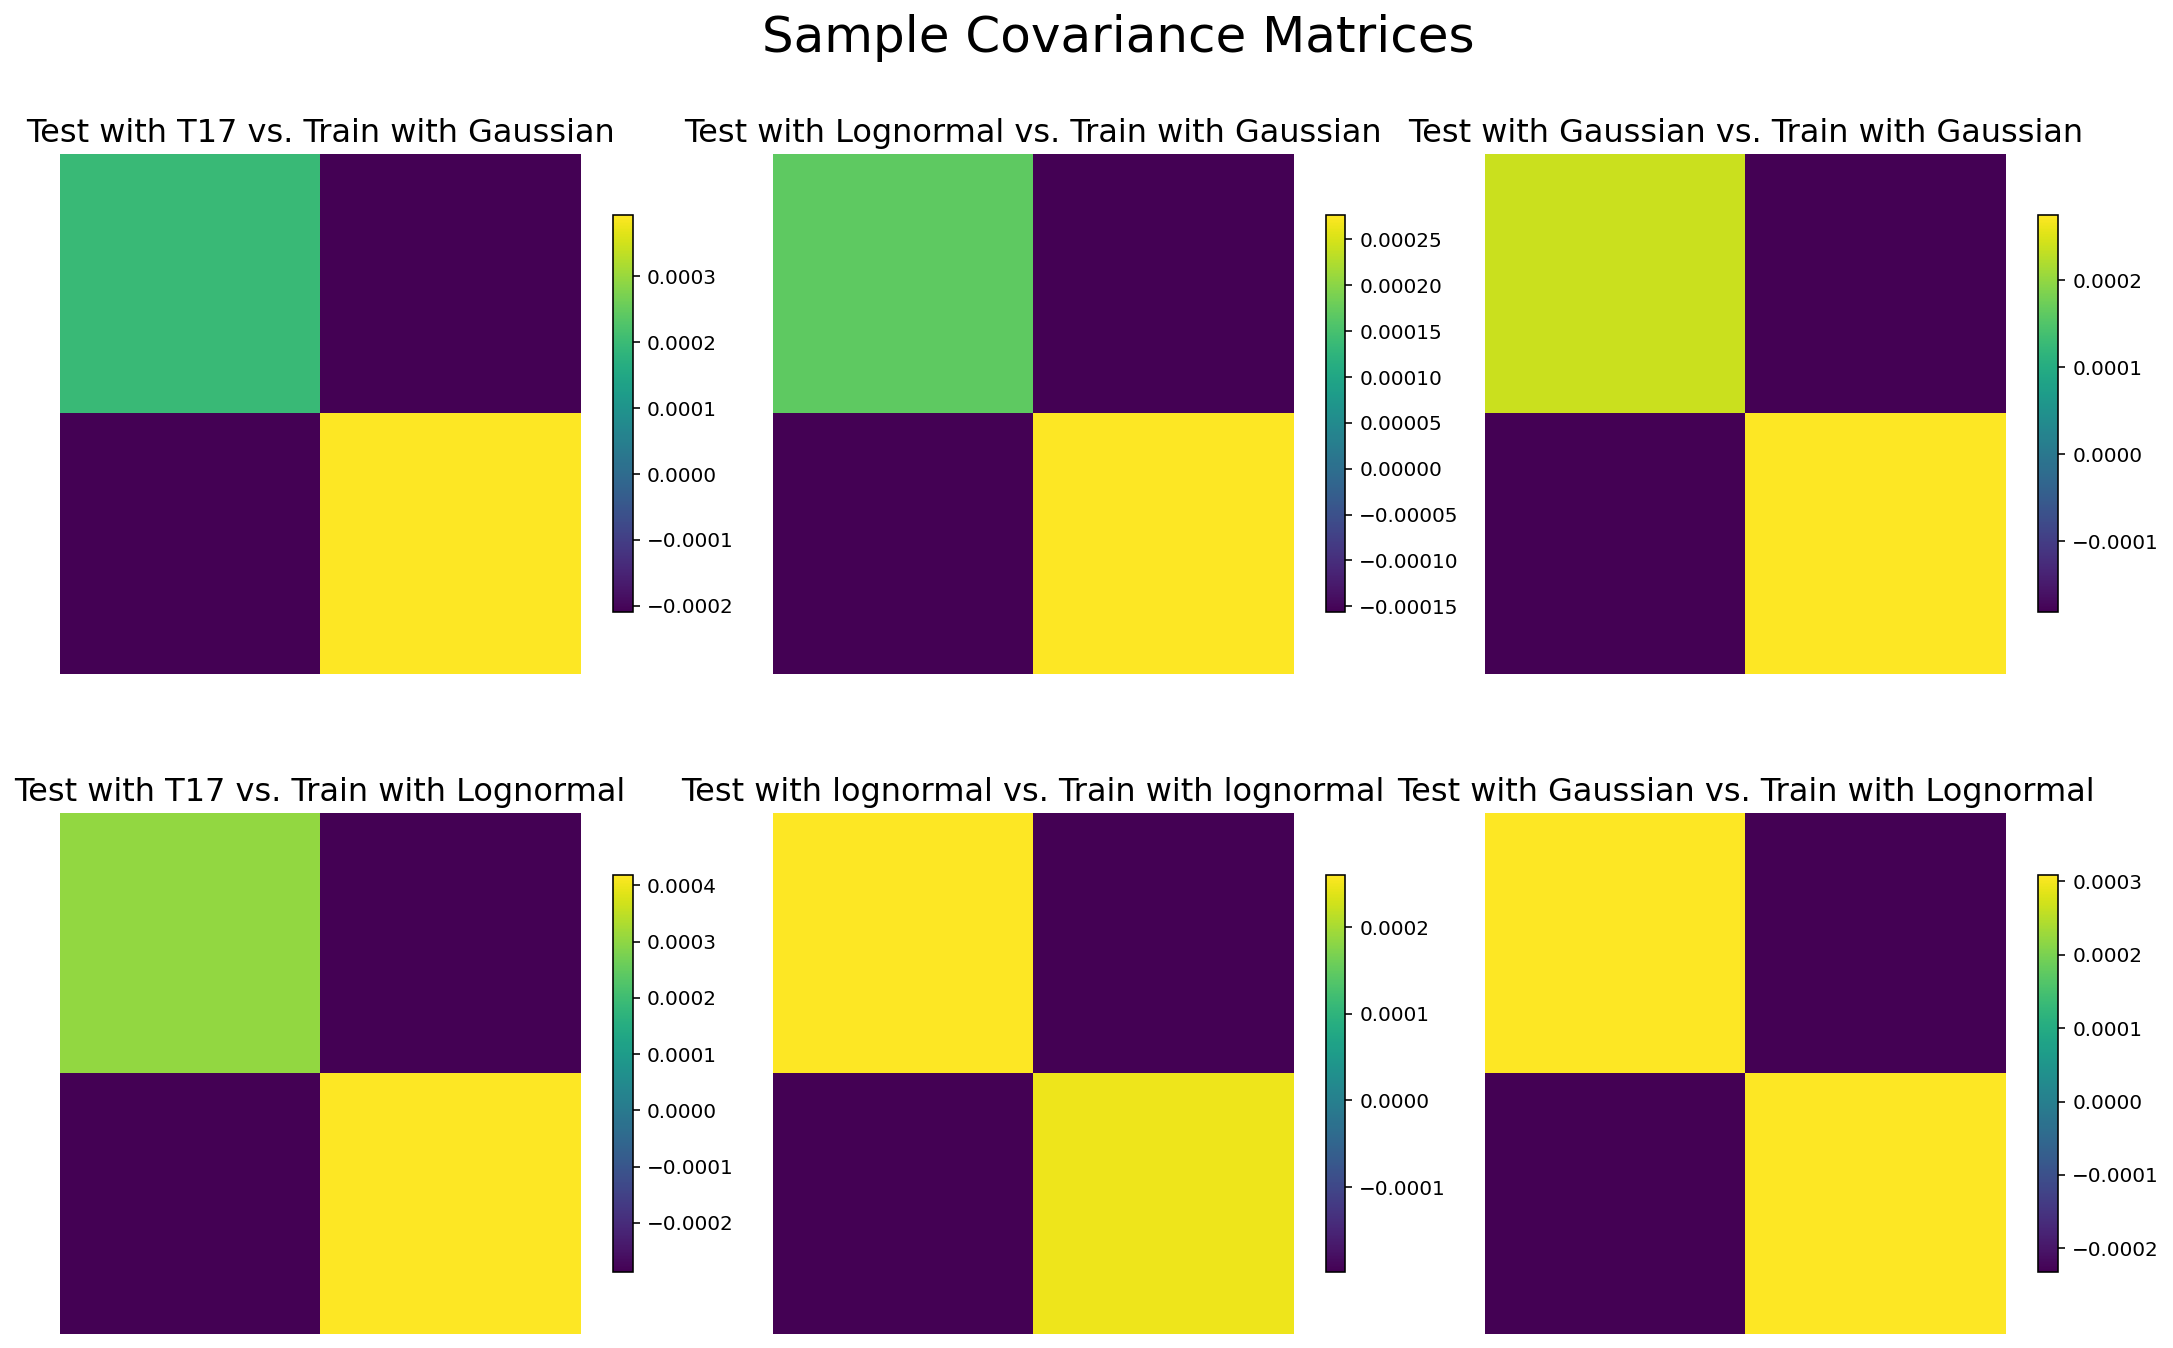

In [23]:
# Create a figure and a grid of subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
plt.subplots_adjust(hspace=0.4)

# List of covariance matrices and their corresponding titles
cov_matrices_KDE_1 = [
    cov_T17_Gauss_1_KDE, cov_lognormal_1_Gauss_1_KDE, cov_Gauss_1_Gauss_1_KDE
    , cov_T17_lognormal_1_KDE, cov_lognormal_1_lognormal_1_KDE, cov_Gauss_1_lognormal_1_KDE
]
titles = [
    'Test with T17 vs. Train with Gaussian', 'Test with Lognormal vs. Train with Gaussian',
    'Test with Gaussian vs. Train with Gaussian', 'Test with T17 vs. Train with Lognormal',
    'Test with lognormal vs. Train with lognormal', 'Test with Gaussian vs. Train with Lognormal'
]

# Loop through subplots and plot each covariance matrix
for ax, cov_matrix, title in zip(axes.flatten(), cov_matrices_KDE_1, titles):
    im = ax.imshow(cov_matrix, cmap='viridis')
    ax.set_title(title, fontsize=16)
    ax.axis('off')
    fig.colorbar(im, ax=ax, shrink=0.6)

# Add a title and display the plot
fig.suptitle('Sample Covariance Matrices', fontsize=25)
plt.tight_layout()
#plt.savefig('/home/r/R.Kanaki/Master_Arbeit_Final/Plot/Posterior_v6/cov_KDE.jpg',bbox_inches='tight')
plt.show()

In [24]:
prior_ranges = {'\Omega_m': (0.15, 0.45), '\sigma_8': (0.5, 1.1)}
param_names = ['\Omega_m', '\sigma_8']
nsamp = 100000
samples_T17_lognormal_1_KDE                   = np.random.multivariate_normal(mu_T17_lognormal_1, cov_T17_lognormal_1_KDE, size=nsamp)
samples_T17_lognormal_2_KDE                   = np.random.multivariate_normal(mu_T17_lognormal_1, cov_T17_lognormal_2_KDE, size=nsamp)
samples_Gauss_1_lognormal_1_KDE               = np.random.multivariate_normal(mu_Gauss_1_lognormal_1, cov_Gauss_1_lognormal_1_KDE, size=nsamp)
samples_Gauss_1_lognormal_2_KDE               = np.random.multivariate_normal(mu_Gauss_1_lognormal_2, cov_Gauss_1_lognormal_2_KDE, size=nsamp)
samples_Gauss_2_lognormal_1_KDE               = np.random.multivariate_normal(mu_Gauss_2_lognormal_1, cov_Gauss_2_lognormal_1_KDE, size=nsamp)
samples_Gauss_2_lognormal_2_KDE               = np.random.multivariate_normal(mu_Gauss_2_lognormal_2, cov_Gauss_2_lognormal_2_KDE, size=nsamp)
samples_lognormal_1_lognormal_1_KDE           = np.random.multivariate_normal(mu_lognormal_1_lognormal_1, cov_lognormal_1_lognormal_1_KDE, size=nsamp)
samples_lognormal_1_lognormal_2_KDE           = np.random.multivariate_normal(mu_lognormal_1_lognormal_2, cov_lognormal_1_lognormal_2_KDE, size=nsamp)
samples_lognormal_2_lognormal_1_KDE           = np.random.multivariate_normal(mu_lognormal_2_lognormal_1, cov_lognormal_2_lognormal_1_KDE, size=nsamp)
samples_lognormal_2_lognormal_2_KDE           = np.random.multivariate_normal(mu_lognormal_2_lognormal_2, cov_lognormal_2_lognormal_2_KDE, size=nsamp)
samples_T17_lognormal_1_mcsamples_KDE         = MCSamples(samples=samples_T17_lognormal_1_KDE, names=param_names, labels=param_names, label='T17 samples', ranges=prior_ranges)
samples_T17_lognormal_2_mcsamples_KDE         = MCSamples(samples=samples_T17_lognormal_2_KDE, names=param_names, labels=param_names, label='T17 samples', ranges=prior_ranges)
samples_lognormal_1_lognormal_1_mcsamples_KDE = MCSamples(samples=samples_lognormal_1_lognormal_1_KDE, names=param_names, labels=param_names, label='lognormal samples', ranges=prior_ranges)
samples_lognormal_1_lognormal_2_mcsamples_KDE = MCSamples(samples=samples_lognormal_1_lognormal_2_KDE, names=param_names, labels=param_names, label='lognormal samples', ranges=prior_ranges)
samples_lognormal_2_lognormal_1_mcsamples_KDE = MCSamples(samples=samples_lognormal_2_lognormal_1_KDE, names=param_names, labels=param_names, label='lognormal samples', ranges=prior_ranges)
samples_lognormal_2_lognormal_2_mcsamples_KDE = MCSamples(samples=samples_lognormal_2_lognormal_2_KDE, names=param_names, labels=param_names, label='lognormal samples', ranges=prior_ranges)
samples_Gauss_1_lognormal_1_mcsamples_KDE     = MCSamples(samples=samples_Gauss_1_lognormal_1_KDE, names=param_names, labels=param_names, label='Gauss samples', ranges=prior_ranges)
samples_Gauss_1_lognormal_2_mcsamples_KDE     = MCSamples(samples=samples_Gauss_1_lognormal_2_KDE, names=param_names, labels=param_names, label='Gauss samples', ranges=prior_ranges)
samples_Gauss_2_lognormal_1_mcsamples_KDE     = MCSamples(samples=samples_Gauss_2_lognormal_1_KDE, names=param_names, labels=param_names, label='Gauss samples', ranges=prior_ranges)
samples_Gauss_2_lognormal_2_mcsamples_KDE     = MCSamples(samples=samples_Gauss_2_lognormal_2_KDE, names=param_names, labels=param_names, label='Gauss samples', ranges=prior_ranges)
all_samples_lognormal_11_KDE = [samples_T17_lognormal_1_mcsamples_KDE, samples_lognormal_1_lognormal_1_mcsamples_KDE, samples_Gauss_1_lognormal_1_mcsamples_KDE]
all_samples_lognormal_12_KDE = [samples_T17_lognormal_2_mcsamples_KDE, samples_lognormal_1_lognormal_2_mcsamples_KDE, samples_Gauss_1_lognormal_2_mcsamples_KDE]
all_samples_lognormal_21_KDE = [samples_T17_lognormal_1_mcsamples_KDE, samples_lognormal_2_lognormal_1_mcsamples_KDE, samples_Gauss_2_lognormal_1_mcsamples_KDE]
all_samples_lognormal_22_KDE = [samples_T17_lognormal_2_mcsamples_KDE, samples_lognormal_2_lognormal_2_mcsamples_KDE, samples_Gauss_2_lognormal_2_mcsamples_KDE]
labels = ['T17', 'lognormal', 'Gauß']

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


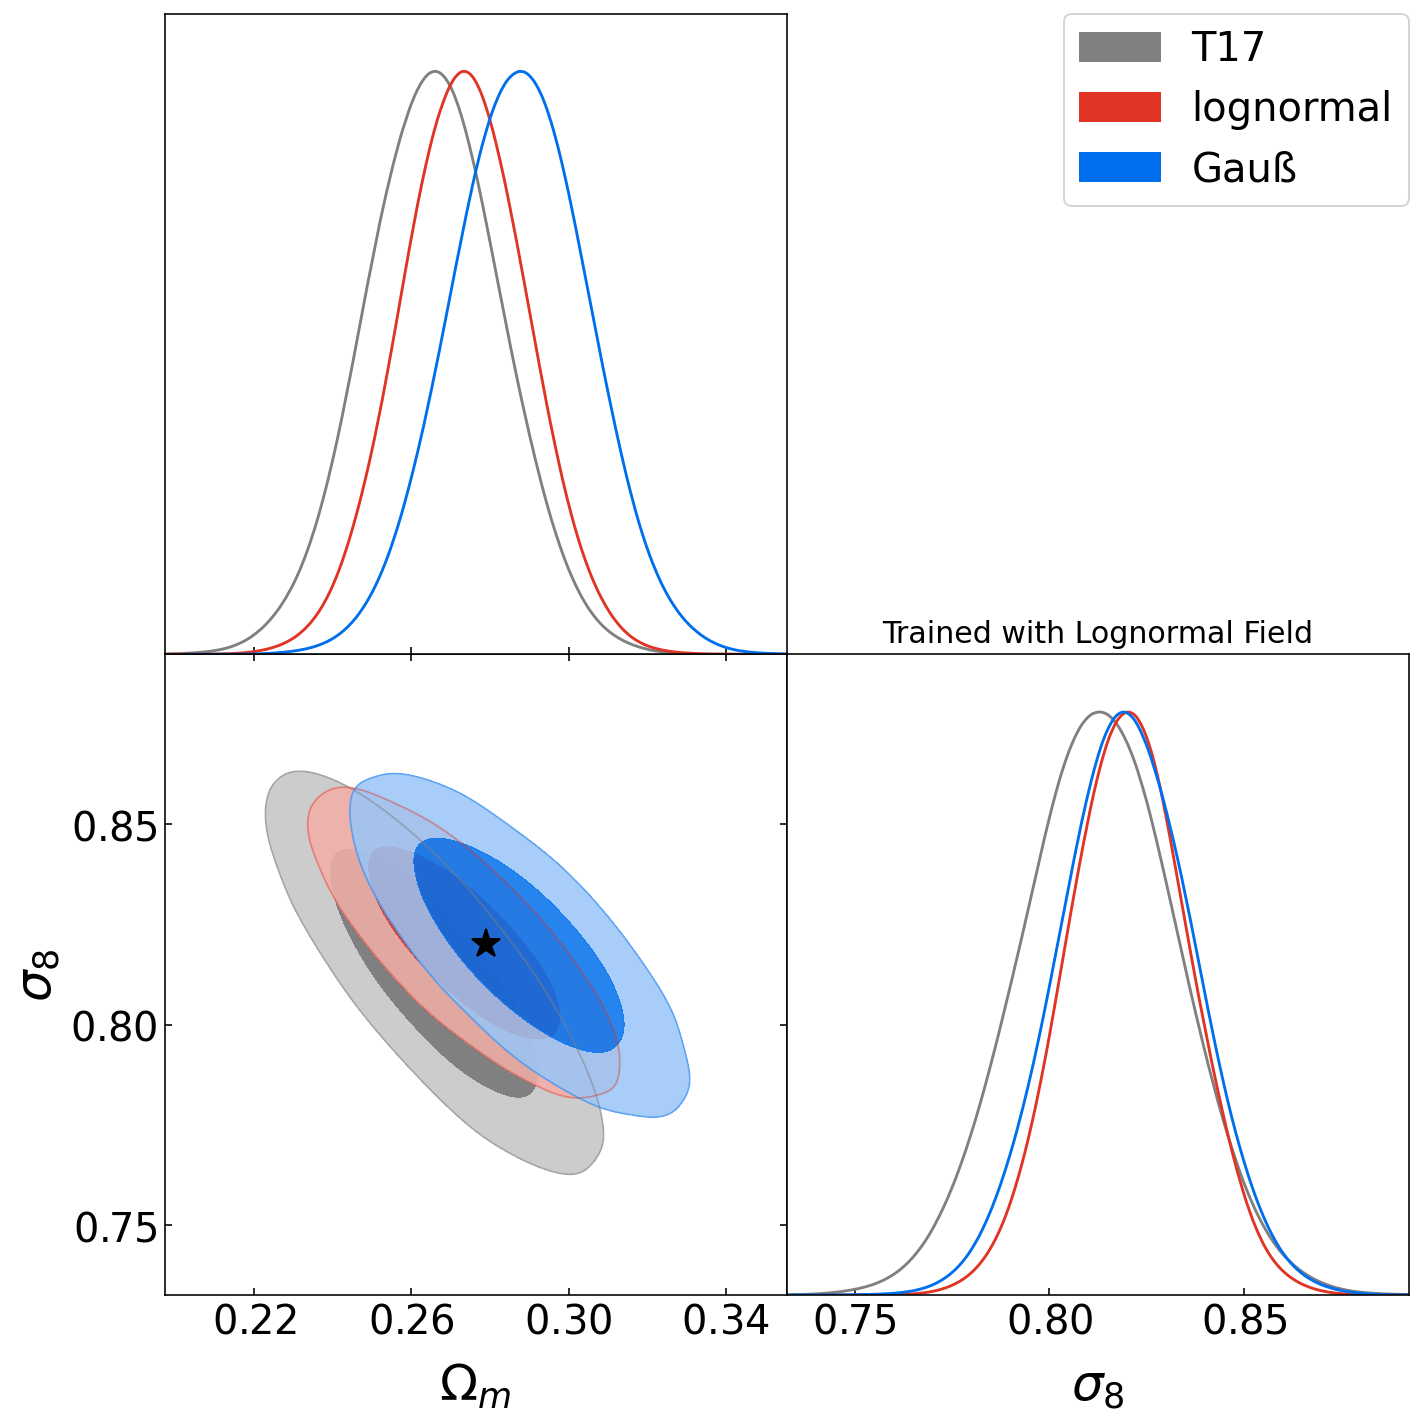

In [25]:
# Create a getdist Plotter
g = plots.get_subplot_plotter(width_inch=10)
g.settings.axes_fontsize = 20
g.settings.lab_fontsize = 25
g.settings.legend_fontsize = 20
# Plot the triangle plot with all posterior distributions and priors
g.triangle_plot(all_samples_lognormal_11_KDE, filled=True, legend_labels=labels, legend_loc='upper right')
plt.title('Trained with Lognormal Field',fontsize=15)
plt.scatter(fiducial_Omega_M, fiducial_sigma_8, marker='*', s=300, label="fiducial cosmology")
g.subplots[1, 0].plot([fiducial_Omega_M], [fiducial_sigma_8], marker='*', label='Fiducial Cosmology', markersize=15, color="black")
#plt.savefig('/home/r/R.Kanaki/Master_Arbeit_Final//Plot/Posterior_v6/Posterior_Train_lognormal_11_KDE.jpg', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

In [26]:
prior_ranges = {'\Omega_m': (0.15, 0.45), '\sigma_8': (0.5, 1.1)}
param_names = ['\Omega_m', '\sigma_8']
nsamp = 100000
samples_T17_Gauss_1_KDE                   = np.random.multivariate_normal(mu_T17_Gauss_1, cov_T17_Gauss_1_KDE, size=nsamp)
samples_T17_Gauss_2_KDE                   = np.random.multivariate_normal(mu_T17_Gauss_2, cov_T17_Gauss_2_KDE, size=nsamp)
samples_Gauss_1_Gauss_1_KDE               = np.random.multivariate_normal(mu_Gauss_1_Gauss_1, cov_Gauss_1_Gauss_1_KDE, size=nsamp)
samples_Gauss_1_Gauss_2_KDE               = np.random.multivariate_normal(mu_Gauss_1_Gauss_2, cov_Gauss_1_Gauss_2_KDE, size=nsamp)
samples_Gauss_2_Gauss_1_KDE               = np.random.multivariate_normal(mu_Gauss_2_Gauss_1, cov_Gauss_2_Gauss_1_KDE, size=nsamp)
samples_Gauss_2_Gauss_2_KDE               = np.random.multivariate_normal(mu_Gauss_2_Gauss_2, cov_Gauss_2_Gauss_2_KDE, size=nsamp)
samples_lognormal_1_Gauss_1_KDE           = np.random.multivariate_normal(mu_lognormal_1_Gauss_1, cov_lognormal_1_Gauss_1_KDE, size=nsamp)
samples_lognormal_1_Gauss_2_KDE           = np.random.multivariate_normal(mu_lognormal_1_Gauss_2, cov_lognormal_1_Gauss_2_KDE, size=nsamp)
samples_lognormal_2_Gauss_1_KDE           = np.random.multivariate_normal(mu_lognormal_2_Gauss_1, cov_lognormal_2_Gauss_1_KDE, size=nsamp)
samples_lognormal_2_Gauss_2_KDE           = np.random.multivariate_normal(mu_lognormal_2_Gauss_2, cov_lognormal_2_Gauss_2_KDE, size=nsamp)
samples_T17_Gauss_1_mcsamples_KDE         = MCSamples(samples=samples_T17_Gauss_1_KDE, names=param_names, labels=param_names, label='T17 samples', ranges=prior_ranges)
samples_T17_Gauss_2_mcsamples_KDE         = MCSamples(samples=samples_T17_Gauss_2_KDE, names=param_names, labels=param_names, label='T17 samples', ranges=prior_ranges)
samples_lognormal_1_Gauss_1_mcsamples_KDE = MCSamples(samples=samples_lognormal_1_Gauss_1_KDE, names=param_names, labels=param_names, label='lognormal samples', ranges=prior_ranges)
samples_lognormal_1_Gauss_2_mcsamples_KDE = MCSamples(samples=samples_lognormal_1_Gauss_2_KDE, names=param_names, labels=param_names, label='lognormal samples', ranges=prior_ranges)
samples_lognormal_2_Gauss_1_mcsamples_KDE = MCSamples(samples=samples_lognormal_2_Gauss_1_KDE, names=param_names, labels=param_names, label='lognormal samples', ranges=prior_ranges)
samples_lognormal_2_Gauss_2_mcsamples_KDE = MCSamples(samples=samples_lognormal_2_Gauss_2_KDE, names=param_names, labels=param_names, label='lognormal samples', ranges=prior_ranges)
samples_Gauss_1_Gauss_1_mcsamples_KDE     = MCSamples(samples=samples_Gauss_1_Gauss_1_KDE, names=param_names, labels=param_names, label='Gauss samples', ranges=prior_ranges)
samples_Gauss_1_Gauss_2_mcsamples_KDE     = MCSamples(samples=samples_Gauss_1_Gauss_2_KDE, names=param_names, labels=param_names, label='Gauss samples', ranges=prior_ranges)
samples_Gauss_2_Gauss_1_mcsamples_KDE     = MCSamples(samples=samples_Gauss_2_Gauss_1_KDE, names=param_names, labels=param_names, label='Gauss samples', ranges=prior_ranges)
samples_Gauss_2_Gauss_2_mcsamples_KDE     = MCSamples(samples=samples_Gauss_2_Gauss_2_KDE, names=param_names, labels=param_names, label='Gauss samples', ranges=prior_ranges)
all_samples_Gauss_11_KDE = [samples_T17_Gauss_1_mcsamples_KDE, samples_lognormal_1_Gauss_1_mcsamples_KDE, samples_Gauss_1_Gauss_1_mcsamples_KDE]
all_samples_Gauss_12_KDE = [samples_T17_Gauss_2_mcsamples_KDE, samples_lognormal_1_Gauss_2_mcsamples_KDE, samples_Gauss_1_Gauss_2_mcsamples_KDE]
all_samples_Gauss_21_KDE = [samples_T17_Gauss_1_mcsamples_KDE, samples_lognormal_2_Gauss_1_mcsamples_KDE, samples_Gauss_2_Gauss_1_mcsamples_KDE]
all_samples_Gauss_22_KDE = [samples_T17_Gauss_2_mcsamples_KDE, samples_lognormal_2_Gauss_2_mcsamples_KDE, samples_Gauss_2_Gauss_2_mcsamples_KDE]
labels = ['T17', 'lognormal', 'Gaussian']

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


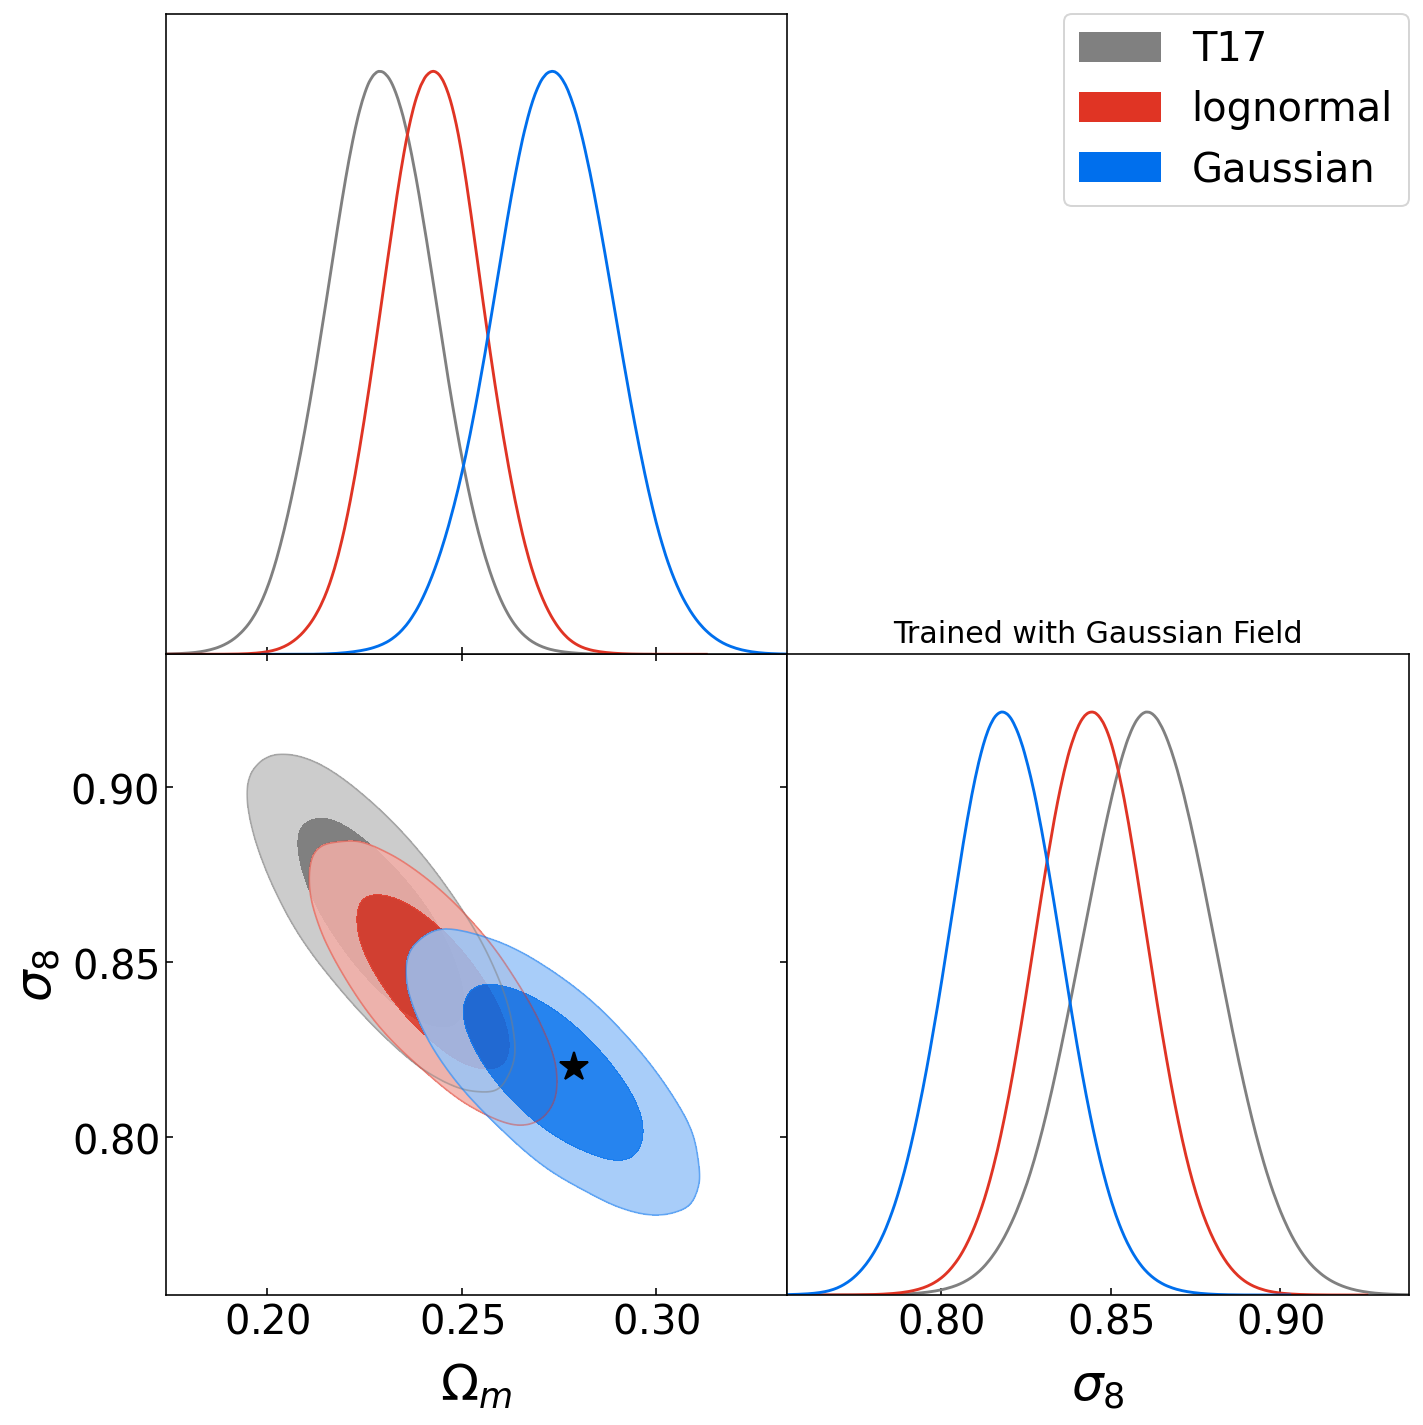

In [28]:
# Create a getdist Plotter
g = plots.get_subplot_plotter(width_inch=10)
g.settings.axes_fontsize = 20
g.settings.lab_fontsize = 25
g.settings.legend_fontsize = 20
# Plot the triangle plot with all posterior distributions and priors

g.triangle_plot(all_samples_Gauss_11_KDE, filled=True, legend_labels=labels, legend_loc='upper right')
plt.title('Trained with Gaussian Field',fontsize=15)
plt.scatter(fiducial_Omega_M, fiducial_sigma_8, marker='*', s=300, label="fiducial cosmology")
g.subplots[1, 0].plot([fiducial_Omega_M], [fiducial_sigma_8], marker='*', label='Fiducial Cosmology', markersize=15, color="black")
#plt.savefig('/home/r/R.Kanaki/Master_Arbeit_Final//Plot/Posterior_v6/Posterior_Train_Gauss_11_KDE.jpg', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

#### Ok like clouds of point nice...
#### I don't understand why people are plotting posterior... Since we are supposed to be an Bayesian...
#### Es ist wie eine Frage, warum sind Schwabe geizig?, naja klar weil Schwabe Schwabe sind. Alter Schwabe...

# Part 3. Parameter Covariance from GCNN Model

#### Erstmal rechne ich rück, sonst verwirre ich später.
#### $L=\begin{pmatrix} L_1 & 0\\ L_3 & L_2 \end{pmatrix}=\begin{pmatrix} e^{y_2} & 0\\ y_4 & e^{y_3} \end{pmatrix}$
####  $\Sigma=\begin{pmatrix} \sigma^2_1 & r\sigma_1\sigma_2 \\ r\sigma_1\sigma_2 & \sigma^2_2 \end{pmatrix}=\begin{pmatrix} L^2_1 & L_3L_1\\ L_3L_1 & L^2_2 \end{pmatrix}=\begin{pmatrix} e^{2y_2} & y_4e^{y_2}\\ y_4e^{y_2} & {y_4}^2+e^{2y_3} \end{pmatrix}$
#### Parameter Auswahl von $L$ ist beliebig, warum benutze ich $e$ Funkition? Vllt kann ich was anderes nehmen.

In [29]:
y_2_T17_Gauss_1 = prediction_T17_Gauss_1[:,2]
y_3_T17_Gauss_1 = prediction_T17_Gauss_1[:,3]
y_4_T17_Gauss_1 = prediction_T17_Gauss_1[:,4]
y_2_T17_Gauss_2 = prediction_T17_Gauss_2[:,2]
y_3_T17_Gauss_2 = prediction_T17_Gauss_2[:,3]
y_4_T17_Gauss_2 = prediction_T17_Gauss_2[:,4]
parameter_est_T17_Gauss_1 = np.array((prediction_T17_Gauss_1[:,0],prediction_T17_Gauss_1[:,1])).T
parameter_est_T17_Gauss_2 = np.array((prediction_T17_Gauss_2[:,0],prediction_T17_Gauss_2[:,1])).T

y_2_Gauss_1_Gauss_1 = prediction_Gauss_1_Gauss_1[:,2]
y_3_Gauss_1_Gauss_1 = prediction_Gauss_1_Gauss_1[:,3]
y_4_Gauss_1_Gauss_1 = prediction_Gauss_1_Gauss_1[:,4]
y_2_Gauss_2_Gauss_1 = prediction_Gauss_2_Gauss_1[:,2]
y_3_Gauss_2_Gauss_1 = prediction_Gauss_2_Gauss_1[:,3]
y_4_Gauss_2_Gauss_1 = prediction_Gauss_2_Gauss_1[:,4]
y_2_Gauss_1_Gauss_2 = prediction_Gauss_1_Gauss_2[:,2]
y_3_Gauss_1_Gauss_2 = prediction_Gauss_1_Gauss_2[:,3]
y_4_Gauss_1_Gauss_2 = prediction_Gauss_1_Gauss_2[:,4]
y_2_Gauss_2_Gauss_2 = prediction_Gauss_2_Gauss_2[:,2]
y_3_Gauss_2_Gauss_2 = prediction_Gauss_2_Gauss_2[:,3]
y_4_Gauss_2_Gauss_2 = prediction_Gauss_2_Gauss_2[:,4]
parameter_est_Gauss_1_Gauss_1 = np.array((prediction_Gauss_1_Gauss_1[:,0],prediction_Gauss_1_Gauss_1[:,1])).T
parameter_est_Gauss_1_Gauss_2 = np.array((prediction_Gauss_1_Gauss_2[:,0],prediction_Gauss_1_Gauss_2[:,1])).T
parameter_est_Gauss_2_Gauss_1 = np.array((prediction_Gauss_2_Gauss_1[:,0],prediction_Gauss_2_Gauss_1[:,1])).T
parameter_est_Gauss_2_Gauss_2 = np.array((prediction_Gauss_2_Gauss_2[:,0],prediction_Gauss_2_Gauss_2[:,1])).T

y_2_lognormal_1_Gauss_1 = prediction_lognormal_1_Gauss_1[:,2]
y_3_lognormal_1_Gauss_1 = prediction_lognormal_1_Gauss_1[:,3]
y_4_lognormal_1_Gauss_1 = prediction_lognormal_1_Gauss_1[:,4]
y_2_lognormal_2_Gauss_1 = prediction_lognormal_2_Gauss_1[:,2]
y_3_lognormal_2_Gauss_1 = prediction_lognormal_2_Gauss_1[:,3]
y_4_lognormal_2_Gauss_1 = prediction_lognormal_2_Gauss_1[:,4]
y_2_lognormal_1_Gauss_2 = prediction_lognormal_1_Gauss_2[:,2]
y_3_lognormal_1_Gauss_2 = prediction_lognormal_1_Gauss_2[:,3]
y_4_lognormal_1_Gauss_2 = prediction_lognormal_1_Gauss_2[:,4]
y_2_lognormal_2_Gauss_2 = prediction_lognormal_2_Gauss_2[:,2]
y_3_lognormal_2_Gauss_2 = prediction_lognormal_2_Gauss_2[:,3]
y_4_lognormal_2_Gauss_2 = prediction_lognormal_2_Gauss_2[:,4]
parameter_est_lognormal_1_Gauss_1 = np.array((prediction_lognormal_1_Gauss_1[:,0],prediction_lognormal_1_Gauss_1[:,1])).T
parameter_est_lognormal_1_Gauss_2 = np.array((prediction_lognormal_1_Gauss_2[:,0],prediction_lognormal_1_Gauss_2[:,1])).T
parameter_est_lognormal_2_Gauss_1 = np.array((prediction_lognormal_2_Gauss_1[:,0],prediction_lognormal_2_Gauss_1[:,1])).T
parameter_est_lognormal_2_Gauss_2 = np.array((prediction_lognormal_2_Gauss_2[:,0],prediction_lognormal_2_Gauss_2[:,1])).T

y_2_T17_lognormal_1 = prediction_T17_lognormal_1[:,2]
y_3_T17_lognormal_1 = prediction_T17_lognormal_1[:,3]
y_4_T17_lognormal_1 = prediction_T17_lognormal_1[:,4]
y_2_T17_lognormal_2 = prediction_T17_lognormal_2[:,2]
y_3_T17_lognormal_2 = prediction_T17_lognormal_2[:,3]
y_4_T17_lognormal_2 = prediction_T17_lognormal_2[:,4]
parameter_est_T17_lognormal_1 = np.array((prediction_T17_lognormal_1[:,0],prediction_T17_lognormal_1[:,1])).T
parameter_est_T17_lognormal_2 = np.array((prediction_T17_lognormal_2[:,0],prediction_T17_lognormal_2[:,1])).T

y_2_Gauss_1_lognormal_1 = prediction_Gauss_1_lognormal_1[:,2]
y_3_Gauss_1_lognormal_1 = prediction_Gauss_1_lognormal_1[:,3]
y_4_Gauss_1_lognormal_1 = prediction_Gauss_1_lognormal_1[:,4]
y_2_Gauss_2_lognormal_1 = prediction_Gauss_2_lognormal_1[:,2]
y_3_Gauss_2_lognormal_1 = prediction_Gauss_2_lognormal_1[:,3]
y_4_Gauss_2_lognormal_1 = prediction_Gauss_2_lognormal_1[:,4]
y_2_Gauss_1_lognormal_2 = prediction_Gauss_1_lognormal_2[:,2]
y_3_Gauss_1_lognormal_2 = prediction_Gauss_1_lognormal_2[:,3]
y_4_Gauss_1_lognormal_2 = prediction_Gauss_1_lognormal_2[:,4]
y_2_Gauss_2_lognormal_2 = prediction_Gauss_2_lognormal_2[:,2]
y_3_Gauss_2_lognormal_2 = prediction_Gauss_2_lognormal_2[:,3]
y_4_Gauss_2_lognormal_2 = prediction_Gauss_2_lognormal_2[:,4]
parameter_est_Gauss_1_lognormal_1 = np.array((prediction_Gauss_1_lognormal_1[:,0],prediction_Gauss_1_lognormal_1[:,1])).T
parameter_est_Gauss_1_lognormal_2 = np.array((prediction_Gauss_1_lognormal_2[:,0],prediction_Gauss_1_lognormal_2[:,1])).T
parameter_est_Gauss_2_lognormal_1 = np.array((prediction_Gauss_2_lognormal_1[:,0],prediction_Gauss_2_lognormal_1[:,1])).T
parameter_est_Gauss_2_lognormal_2 = np.array((prediction_Gauss_2_lognormal_2[:,0],prediction_Gauss_2_lognormal_2[:,1])).T

y_2_lognormal_1_lognormal_1 = prediction_lognormal_1_lognormal_1[:,2]
y_3_lognormal_1_lognormal_1 = prediction_lognormal_1_lognormal_1[:,3]
y_4_lognormal_1_lognormal_1 = prediction_lognormal_1_lognormal_1[:,4]
y_2_lognormal_2_lognormal_1 = prediction_lognormal_2_lognormal_1[:,2]
y_3_lognormal_2_lognormal_1 = prediction_lognormal_2_lognormal_1[:,3]
y_4_lognormal_2_lognormal_1 = prediction_lognormal_2_lognormal_1[:,4]
y_2_lognormal_1_lognormal_2 = prediction_lognormal_1_lognormal_2[:,2]
y_3_lognormal_1_lognormal_2 = prediction_lognormal_1_lognormal_2[:,3]
y_4_lognormal_1_lognormal_2 = prediction_lognormal_1_lognormal_2[:,4]
y_2_lognormal_2_lognormal_2 = prediction_lognormal_2_lognormal_2[:,2]
y_3_lognormal_2_lognormal_2 = prediction_lognormal_2_lognormal_2[:,3]
y_4_lognormal_2_lognormal_2 = prediction_lognormal_2_lognormal_2[:,4]
parameter_est_lognormal_1_lognormal_1 = np.array((prediction_lognormal_1_lognormal_1[:,0],prediction_lognormal_1_lognormal_1[:,1])).T
parameter_est_lognormal_1_lognormal_2 = np.array((prediction_lognormal_1_lognormal_2[:,0],prediction_lognormal_1_lognormal_2[:,1])).T
parameter_est_lognormal_2_lognormal_1 = np.array((prediction_lognormal_2_lognormal_1[:,0],prediction_lognormal_2_lognormal_1[:,1])).T
parameter_est_lognormal_2_lognormal_2 = np.array((prediction_lognormal_2_lognormal_2[:,0],prediction_lognormal_2_lognormal_2[:,1])).T

In [30]:
def cov_parametric(y_2,y_3,y_4):
    sig1   = np.exp(2.*y_2)
    sig2   = np.exp(2.*y_3)+(y_4)**2
    r_sig  = y_4*np.exp(y_2)

    cov1       = np.array((sig1, r_sig))
    cov2       = np.array((r_sig, sig2))
    cov_output = np.array((cov1, cov2))
    return cov_output

In [31]:
def cov_parametric_2(y_2,y_3,y_4):
    y_2_mean = np.mean(y_2)
    y_3_mean = np.mean(y_3)
    y_4_mean = np.mean(y_4)
    sig1     = np.exp(2*y_2_mean)
    sig2     = np.exp(2*y_3_mean)+(y_4_mean)**2
    r_sig    = y_4_mean*np.exp(y_2_mean)

    cov1       = np.array((sig1, r_sig))
    cov2       = np.array((r_sig, sig2))
    cov_output = np.array((cov1, cov2))
    return cov_output

#### Also erst mean oder danach mean, es isht mir nischt Würsht, weil es nicht kommutativ ist.

In [35]:
cov_para_T17_Gauss_1             = cov_parametric(y_2_T17_Gauss_1, y_3_T17_Gauss_1, y_4_T17_Gauss_1)
cov_para_T17_Gauss_2             = cov_parametric(y_2_T17_Gauss_2, y_3_T17_Gauss_1, y_4_T17_Gauss_2)

cov_para_Gauss_1_Gauss_1         = cov_parametric(y_2_Gauss_1_Gauss_1, y_3_Gauss_1_Gauss_1, y_4_Gauss_1_Gauss_1)
cov_para_Gauss_1_Gauss_2         = cov_parametric(y_2_Gauss_1_Gauss_2, y_3_Gauss_1_Gauss_2, y_4_Gauss_1_Gauss_2)
cov_para_Gauss_2_Gauss_1         = cov_parametric(y_2_Gauss_2_Gauss_1, y_3_Gauss_2_Gauss_1, y_4_Gauss_2_Gauss_1)
cov_para_Gauss_2_Gauss_2         = cov_parametric(y_2_Gauss_2_Gauss_2, y_3_Gauss_2_Gauss_2, y_4_Gauss_2_Gauss_2)

cov_para_lognormal_1_Gauss_1     = cov_parametric(y_2_lognormal_1_Gauss_1, y_3_lognormal_1_Gauss_1, y_4_lognormal_1_Gauss_1)
cov_para_lognormal_1_Gauss_2     = cov_parametric(y_2_lognormal_1_Gauss_2, y_3_lognormal_1_Gauss_2, y_4_lognormal_1_Gauss_2)
cov_para_lognormal_2_Gauss_1     = cov_parametric(y_2_lognormal_2_Gauss_1, y_3_lognormal_2_Gauss_1, y_4_lognormal_2_Gauss_1)
cov_para_lognormal_2_Gauss_2     = cov_parametric(y_2_lognormal_2_Gauss_2, y_3_lognormal_2_Gauss_2, y_4_lognormal_2_Gauss_2)

cov_para_T17_lognormal_1         = cov_parametric(y_2_T17_lognormal_1, y_3_T17_lognormal_1, y_4_T17_lognormal_1)
cov_para_T17_lognormal_2         = cov_parametric(y_2_T17_lognormal_2, y_3_T17_lognormal_2, y_4_T17_lognormal_2)

cov_para_Gauss_1_lognormal_1     = cov_parametric(y_2_Gauss_1_lognormal_1, y_3_Gauss_1_lognormal_1, y_4_Gauss_1_lognormal_1)
cov_para_Gauss_1_lognormal_2     = cov_parametric(y_2_Gauss_1_lognormal_2, y_3_Gauss_1_lognormal_2, y_4_Gauss_1_lognormal_2)
cov_para_Gauss_2_lognormal_1     = cov_parametric(y_2_Gauss_2_lognormal_1, y_3_Gauss_2_lognormal_1, y_4_Gauss_2_lognormal_1)
cov_para_Gauss_2_lognormal_2     = cov_parametric(y_2_Gauss_2_lognormal_2, y_3_Gauss_2_lognormal_2, y_4_Gauss_2_lognormal_2)

cov_para_lognormal_1_lognormal_1 = cov_parametric(y_2_lognormal_1_lognormal_1, y_3_lognormal_1_lognormal_1, y_4_lognormal_1_lognormal_1)
cov_para_lognormal_1_lognormal_2 = cov_parametric(y_2_lognormal_1_lognormal_2, y_3_lognormal_1_lognormal_2, y_4_lognormal_1_lognormal_2)
cov_para_lognormal_2_lognormal_1 = cov_parametric(y_2_lognormal_2_lognormal_1, y_3_lognormal_2_lognormal_1, y_4_lognormal_2_lognormal_1)
cov_para_lognormal_2_lognormal_2 = cov_parametric(y_2_lognormal_2_lognormal_2, y_3_lognormal_2_lognormal_2, y_4_lognormal_2_lognormal_2)

In [36]:
cov_2_para_T17_Gauss_1             = cov_parametric_2(y_2_T17_Gauss_1, y_3_T17_Gauss_1, y_4_T17_Gauss_1)
cov_2_para_T17_Gauss_2             = cov_parametric_2(y_2_T17_Gauss_2, y_3_T17_Gauss_1, y_4_T17_Gauss_2)

cov_2_para_Gauss_1_Gauss_1         = cov_parametric_2(y_2_Gauss_1_Gauss_1, y_3_Gauss_1_Gauss_1, y_4_Gauss_1_Gauss_1)
cov_2_para_Gauss_1_Gauss_2         = cov_parametric_2(y_2_Gauss_1_Gauss_2, y_3_Gauss_1_Gauss_2, y_4_Gauss_1_Gauss_2)
cov_2_para_Gauss_2_Gauss_1         = cov_parametric_2(y_2_Gauss_2_Gauss_1, y_3_Gauss_2_Gauss_1, y_4_Gauss_2_Gauss_1)
cov_2_para_Gauss_2_Gauss_2         = cov_parametric_2(y_2_Gauss_2_Gauss_2, y_3_Gauss_2_Gauss_2, y_4_Gauss_2_Gauss_2)

cov_2_para_lognormal_1_Gauss_1     = cov_parametric_2(y_2_lognormal_1_Gauss_1, y_3_lognormal_1_Gauss_1, y_4_lognormal_1_Gauss_1)
cov_2_para_lognormal_1_Gauss_2     = cov_parametric_2(y_2_lognormal_1_Gauss_2, y_3_lognormal_1_Gauss_2, y_4_lognormal_1_Gauss_2)
cov_2_para_lognormal_2_Gauss_1     = cov_parametric_2(y_2_lognormal_2_Gauss_1, y_3_lognormal_2_Gauss_1, y_4_lognormal_2_Gauss_1)
cov_2_para_lognormal_2_Gauss_2     = cov_parametric_2(y_2_lognormal_2_Gauss_2, y_3_lognormal_2_Gauss_2, y_4_lognormal_2_Gauss_2)

cov_2_para_T17_lognormal_1         = cov_parametric_2(y_2_T17_lognormal_1, y_3_T17_lognormal_1, y_4_T17_lognormal_1)
cov_2_para_T17_lognormal_2         = cov_parametric_2(y_2_T17_lognormal_2, y_3_T17_lognormal_2, y_4_T17_lognormal_2)

cov_2_para_Gauss_1_lognormal_1     = cov_parametric_2(y_2_Gauss_1_lognormal_1, y_3_Gauss_1_lognormal_1, y_4_Gauss_1_lognormal_1)
cov_2_para_Gauss_1_lognormal_2     = cov_parametric_2(y_2_Gauss_1_lognormal_2, y_3_Gauss_1_lognormal_2, y_4_Gauss_1_lognormal_2)
cov_2_para_Gauss_2_lognormal_1     = cov_parametric_2(y_2_Gauss_2_lognormal_1, y_3_Gauss_2_lognormal_1, y_4_Gauss_2_lognormal_1)
cov_2_para_Gauss_2_lognormal_2     = cov_parametric_2(y_2_Gauss_2_lognormal_2, y_3_Gauss_2_lognormal_2, y_4_Gauss_2_lognormal_2)

cov_2_para_lognormal_1_lognormal_1 = cov_parametric_2(y_2_lognormal_1_lognormal_1, y_3_lognormal_1_lognormal_1, y_4_lognormal_1_lognormal_1)
cov_2_para_lognormal_1_lognormal_2 = cov_parametric_2(y_2_lognormal_1_lognormal_2, y_3_lognormal_1_lognormal_2, y_4_lognormal_1_lognormal_2)
cov_2_para_lognormal_2_lognormal_1 = cov_parametric_2(y_2_lognormal_2_lognormal_1, y_3_lognormal_2_lognormal_1, y_4_lognormal_2_lognormal_1)
cov_2_para_lognormal_2_lognormal_2 = cov_parametric_2(y_2_lognormal_2_lognormal_2, y_3_lognormal_2_lognormal_2, y_4_lognormal_2_lognormal_2)

#### Advice of Oliver: Let's forget precision matrix, are you sure that your covariance follows Wishard distribution?
#### I understand what Oliver's advice, it makes sence, my covariance not necessary to follow Wishard distribution
#### But $C^{-1}\ne\langle C^{-1}\rangle$ is wrong, was soll ich hier machen, Lieber Gott!

In [37]:
cov_T17_Gauss_1_mean             = np.mean(cov_para_T17_Gauss_1, axis=2)
cov_T17_Gauss_2_mean             = np.mean(cov_para_T17_Gauss_2, axis=2)
cov_T17_lognormal_1_mean         = np.mean(cov_para_T17_lognormal_1, axis=2)
cov_T17_lognormal_2_mean         = np.mean(cov_para_T17_lognormal_2, axis=2)
cov_lognormal_1_Gauss_1_mean     = np.mean(cov_para_lognormal_1_Gauss_1, axis=2)
cov_lognormal_1_Gauss_2_mean     = np.mean(cov_para_lognormal_1_Gauss_2, axis=2)
cov_lognormal_2_Gauss_1_mean     = np.mean(cov_para_lognormal_2_Gauss_1, axis=2)
cov_lognormal_2_Gauss_2_mean     = np.mean(cov_para_lognormal_2_Gauss_2, axis=2)
cov_lognormal_1_lognormal_1_mean = np.mean(cov_para_lognormal_1_lognormal_1, axis=2)
cov_lognormal_1_lognormal_2_mean = np.mean(cov_para_lognormal_1_lognormal_2, axis=2)
cov_lognormal_2_lognormal_1_mean = np.mean(cov_para_lognormal_2_lognormal_1, axis=2)
cov_lognormal_2_lognormal_2_mean = np.mean(cov_para_lognormal_2_lognormal_2, axis=2)
cov_Gauss_1_Gauss_1_mean         = np.mean(cov_para_Gauss_1_Gauss_1, axis=2)
cov_Gauss_1_Gauss_2_mean         = np.mean(cov_para_Gauss_1_Gauss_2, axis=2)
cov_Gauss_2_Gauss_1_mean         = np.mean(cov_para_Gauss_2_Gauss_1, axis=2)
cov_Gauss_2_Gauss_2_mean         = np.mean(cov_para_Gauss_2_Gauss_2, axis=2)
cov_Gauss_1_lognormal_1_mean     = np.mean(cov_para_Gauss_1_lognormal_1, axis=2)
cov_Gauss_1_lognormal_2_mean     = np.mean(cov_para_Gauss_1_lognormal_2, axis=2)
cov_Gauss_2_lognormal_1_mean     = np.mean(cov_para_Gauss_2_lognormal_1, axis=2)
cov_Gauss_2_lognormal_2_mean     = np.mean(cov_para_Gauss_2_lognormal_2, axis=2)

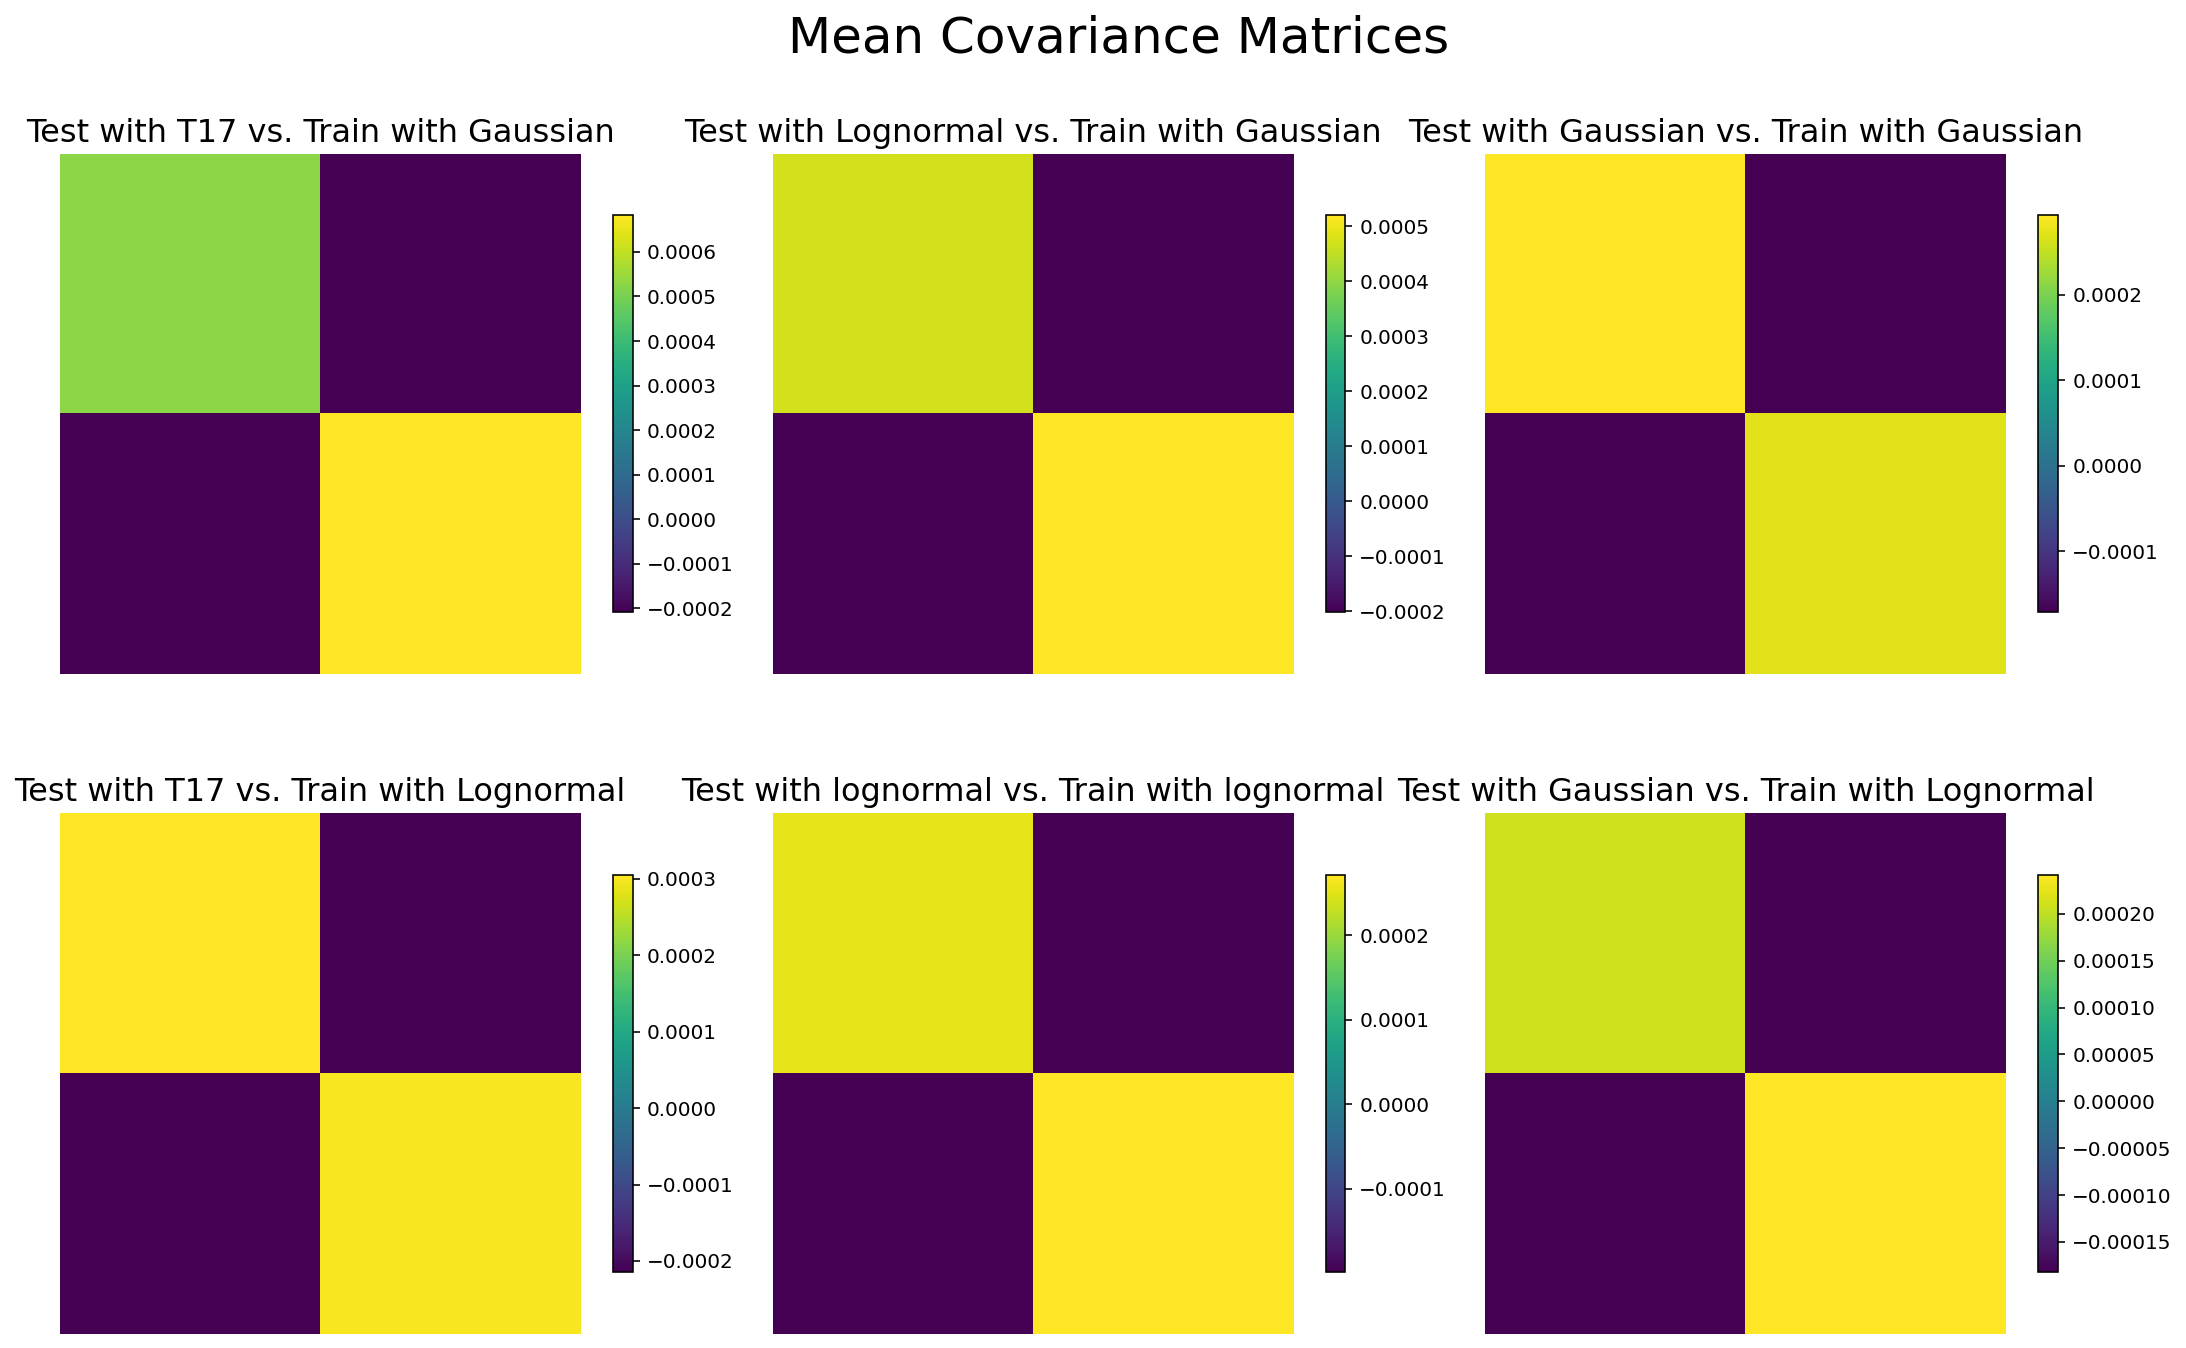

In [38]:
# Create a figure and a grid of subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
plt.subplots_adjust(hspace=0.4)

# List of covariance matrices and their corresponding titles
cov_matrices_11 = [
    cov_T17_Gauss_1_mean, cov_lognormal_1_Gauss_1_mean, cov_Gauss_1_Gauss_1_mean
    , cov_T17_lognormal_1_mean, cov_lognormal_1_lognormal_1_mean, cov_Gauss_1_lognormal_1_mean
]
titles = [
    'Test with T17 vs. Train with Gaussian', 'Test with Lognormal vs. Train with Gaussian',
    'Test with Gaussian vs. Train with Gaussian', 'Test with T17 vs. Train with Lognormal',
    'Test with lognormal vs. Train with lognormal', 'Test with Gaussian vs. Train with Lognormal'
]

# Loop through subplots and plot each covariance matrix
for ax, cov_matrix, title in zip(axes.flatten(), cov_matrices_11, titles):
    im = ax.imshow(cov_matrix, cmap='viridis')
    ax.set_title(title, fontsize=16)
    ax.axis('off')
    fig.colorbar(im, ax=ax, shrink=0.6)

# Add a title and display the plot
fig.suptitle('Mean Covariance Matrices', fontsize=25)
plt.tight_layout()
#plt.savefig('/home/r/R.Kanaki/Master_Arbeit_Final/Plot/Posterior_v6/covs_11.png',bbox_inches='tight')
plt.show()

#### Ich erinerre mich eine Augenuntersuchung, wie heißt es? Landoltring！

In [41]:
prior_ranges = {'\Omega_m': (0.15, 0.45), '\sigma_8': (0.5, 1.1)}
param_names = ['\Omega_m', '\sigma_8']
nsamp = 100000
samples_T17_Gauss_1                   = np.random.multivariate_normal(mu_T17_Gauss_1, cov_T17_Gauss_1_mean, size=nsamp)
samples_T17_Gauss_2                   = np.random.multivariate_normal(mu_T17_Gauss_2, cov_T17_Gauss_2_mean, size=nsamp)
samples_Gauss_1_Gauss_1               = np.random.multivariate_normal(mu_Gauss_1_Gauss_1, cov_Gauss_1_Gauss_1_mean, size=nsamp)
samples_Gauss_1_Gauss_2               = np.random.multivariate_normal(mu_Gauss_1_Gauss_2, cov_Gauss_1_Gauss_2_mean, size=nsamp)
samples_Gauss_2_Gauss_1               = np.random.multivariate_normal(mu_Gauss_2_Gauss_1, cov_Gauss_2_Gauss_1_mean, size=nsamp)
samples_Gauss_2_Gauss_2               = np.random.multivariate_normal(mu_Gauss_2_Gauss_2, cov_Gauss_2_Gauss_2_mean, size=nsamp)
samples_lognormal_1_Gauss_1           = np.random.multivariate_normal(mu_lognormal_1_Gauss_1, cov_lognormal_1_Gauss_1_mean, size=nsamp)
samples_lognormal_1_Gauss_2           = np.random.multivariate_normal(mu_lognormal_1_Gauss_2, cov_lognormal_1_Gauss_2_mean, size=nsamp)
samples_lognormal_2_Gauss_1           = np.random.multivariate_normal(mu_lognormal_2_Gauss_1, cov_lognormal_2_Gauss_1_mean, size=nsamp)
samples_lognormal_2_Gauss_2           = np.random.multivariate_normal(mu_lognormal_2_Gauss_2, cov_lognormal_2_Gauss_2_mean, size=nsamp)
samples_T17_Gauss_1_mcsamples         = MCSamples(samples=samples_T17_Gauss_1, names=param_names, labels=param_names, label='T17 samples', ranges=prior_ranges)
samples_T17_Gauss_2_mcsamples         = MCSamples(samples=samples_T17_Gauss_2, names=param_names, labels=param_names, label='T17 samples', ranges=prior_ranges)
samples_lognormal_1_Gauss_1_mcsamples = MCSamples(samples=samples_lognormal_1_Gauss_1, names=param_names, labels=param_names, label='lognormal samples', ranges=prior_ranges)
samples_lognormal_1_Gauss_2_mcsamples = MCSamples(samples=samples_lognormal_1_Gauss_2, names=param_names, labels=param_names, label='lognormal samples', ranges=prior_ranges)
samples_lognormal_2_Gauss_1_mcsamples = MCSamples(samples=samples_lognormal_2_Gauss_1, names=param_names, labels=param_names, label='lognormal samples', ranges=prior_ranges)
samples_lognormal_2_Gauss_2_mcsamples = MCSamples(samples=samples_lognormal_2_Gauss_2, names=param_names, labels=param_names, label='lognormal samples', ranges=prior_ranges)
samples_Gauss_1_Gauss_1_mcsamples     = MCSamples(samples=samples_Gauss_1_Gauss_1, names=param_names, labels=param_names, label='Gauss samples', ranges=prior_ranges)
samples_Gauss_1_Gauss_2_mcsamples     = MCSamples(samples=samples_Gauss_1_Gauss_2, names=param_names, labels=param_names, label='Gauss samples', ranges=prior_ranges)
samples_Gauss_2_Gauss_1_mcsamples     = MCSamples(samples=samples_Gauss_2_Gauss_1, names=param_names, labels=param_names, label='Gauss samples', ranges=prior_ranges)
samples_Gauss_2_Gauss_2_mcsamples     = MCSamples(samples=samples_Gauss_2_Gauss_2, names=param_names, labels=param_names, label='Gauss samples', ranges=prior_ranges)
all_samples_Gauss_11 = [samples_T17_Gauss_1_mcsamples, samples_lognormal_1_Gauss_1_mcsamples, samples_Gauss_1_Gauss_1_mcsamples]
all_samples_Gauss_12 = [ samples_lognormal_1_Gauss_2_mcsamples, samples_Gauss_1_Gauss_2_mcsamples]
all_samples_Gauss_21 = [samples_T17_Gauss_1_mcsamples, samples_lognormal_2_Gauss_1_mcsamples, samples_Gauss_2_Gauss_1_mcsamples]
all_samples_Gauss_22 = [ samples_lognormal_2_Gauss_2_mcsamples, samples_Gauss_2_Gauss_2_mcsamples]
labels = ['T17', 'lognormal', 'Gaussian']

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


In [42]:
samples_test= [samples_Gauss_1_Gauss_1_mcsamples,samples_2_Gauss_1_Gauss_1_mcsamples]
Labels_Test = ['Mean Covariance','Mean Outputs']

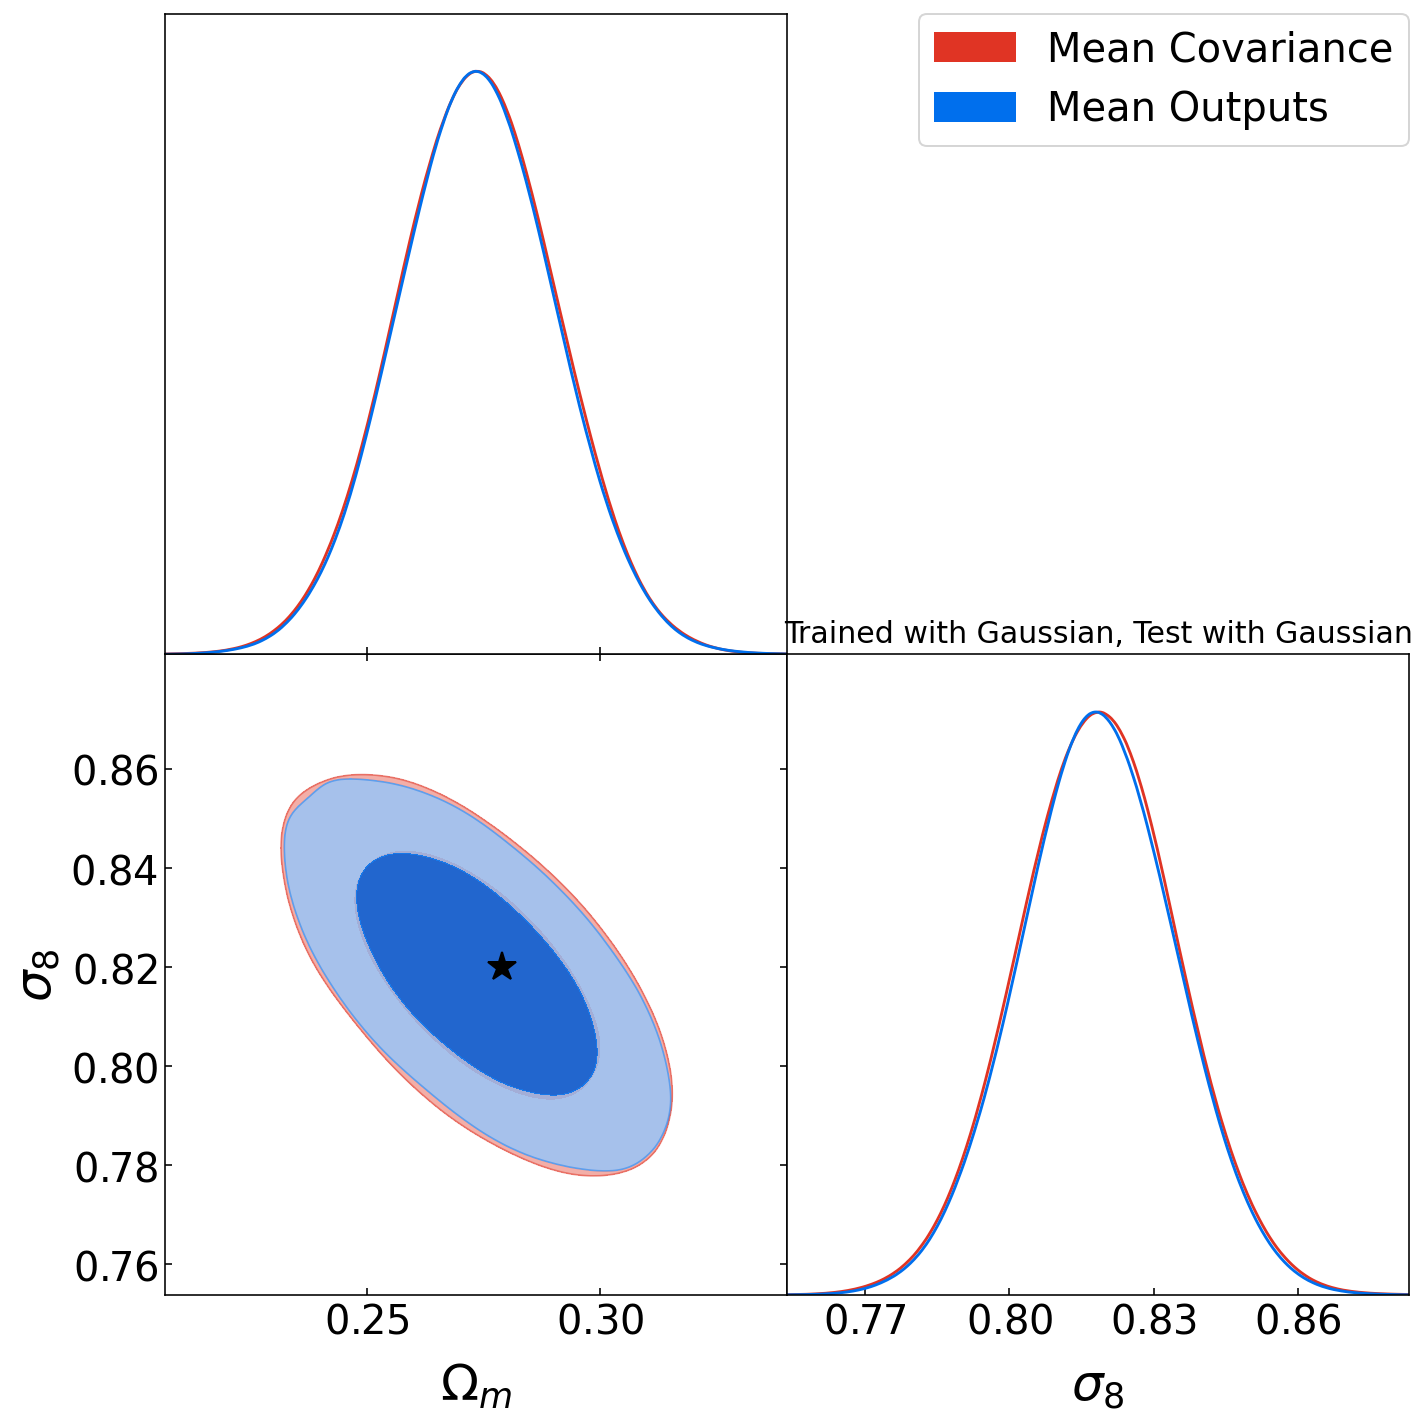

In [43]:
g = plots.get_subplot_plotter(width_inch=10)
g.settings.axes_fontsize = 20
g.settings.lab_fontsize = 25
g.settings.legend_fontsize = 20
g.triangle_plot(samples_test, filled=True, legend_labels=Labels_Test, legend_loc='upper right')
g.subplots[1, 0].plot([fiducial_Omega_M], [fiducial_sigma_8], marker='*', label='Fiducial Cosmology', markersize=15, color="black")
#legend =g.legend(fontsize=15)
plt.title('Trained with Gaussian, Test with Gaussian',fontsize=15)
plt.savefig('/home/r/R.Kanaki/Master_Arbeit_Final//Plot/Posterior_v6/Posterior_Test.jpg', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

#### Also fast kommutativ, Super!

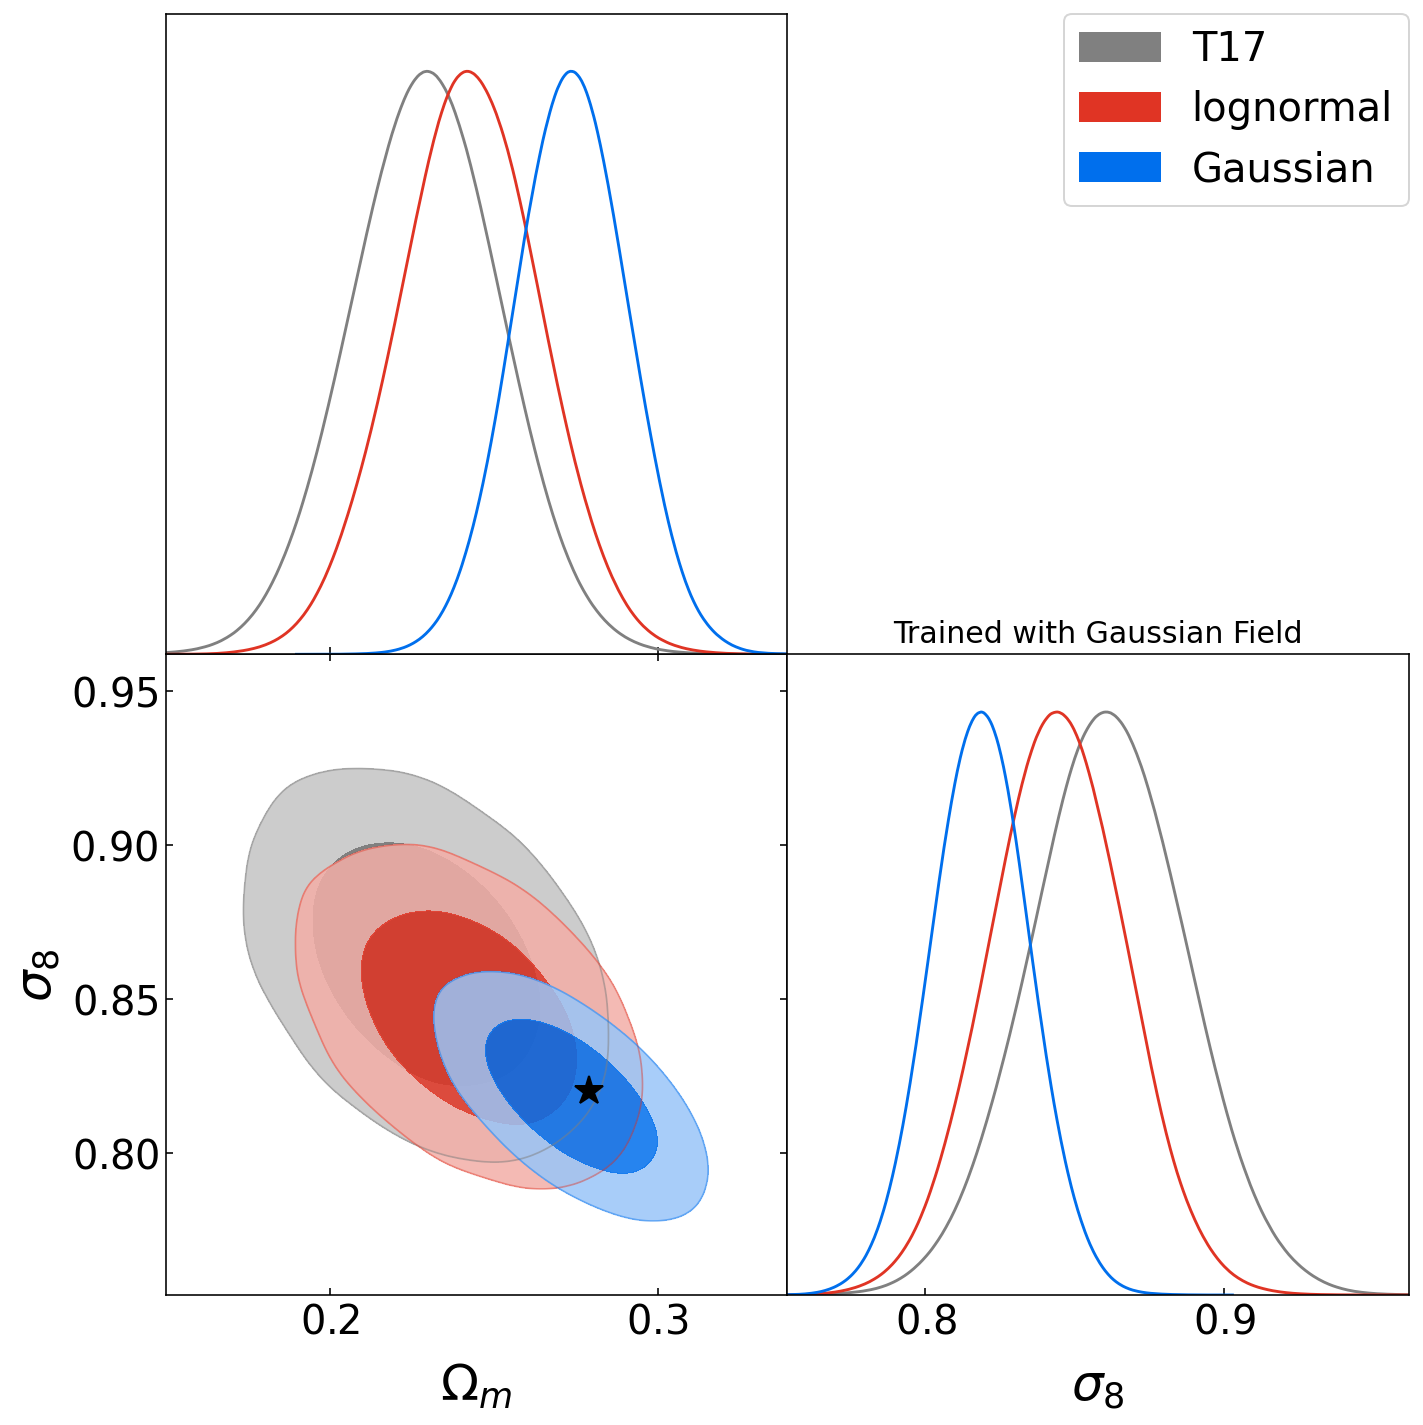

In [44]:
g = plots.get_subplot_plotter(width_inch=10)
g.settings.axes_fontsize = 20
g.settings.lab_fontsize = 25
g.settings.legend_fontsize = 20
g.triangle_plot(all_samples_Gauss_11, filled=True, legend_labels=labels, legend_loc='upper right')
g.subplots[1, 0].plot([fiducial_Omega_M], [fiducial_sigma_8], marker='*', label='Fiducial Cosmology', markersize=15, color="black")
plt.title('Trained with Gaussian Field',fontsize=15)
plt.savefig('/home/r/R.Kanaki/Master_Arbeit_Final//Plot/Posterior_v6/Posterior_Train_Gauss_11.jpg', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

#### Genau, was ist was ich sehen wollte!

In [45]:
prior_ranges = {'\Omega_m': (0.15, 0.45), '\sigma_8': (0.5, 1.1)}
param_names = ['\Omega_m', '\sigma_8']
nsamp = 100000
samples_T17_lognormal_1                   = np.random.multivariate_normal(mu_T17_lognormal_1, cov_T17_lognormal_1_mean, size=nsamp)
samples_T17_lognormal_2                   = np.random.multivariate_normal(mu_T17_lognormal_2, cov_T17_lognormal_2_mean, size=nsamp)
samples_Gauss_1_lognormal_1               = np.random.multivariate_normal(mu_Gauss_1_lognormal_1, cov_Gauss_1_lognormal_1_mean, size=nsamp)
samples_Gauss_1_lognormal_2               = np.random.multivariate_normal(mu_Gauss_1_lognormal_2, cov_Gauss_1_lognormal_2_mean, size=nsamp)
samples_Gauss_2_lognormal_1               = np.random.multivariate_normal(mu_Gauss_2_lognormal_1, cov_Gauss_2_lognormal_1_mean, size=nsamp)
samples_Gauss_2_lognormal_2               = np.random.multivariate_normal(mu_Gauss_2_lognormal_2, cov_Gauss_2_lognormal_2_mean, size=nsamp)
samples_lognormal_1_lognormal_1           = np.random.multivariate_normal(mu_lognormal_1_lognormal_1, cov_lognormal_1_lognormal_1_mean, size=nsamp)
samples_lognormal_1_lognormal_2           = np.random.multivariate_normal(mu_lognormal_1_lognormal_2, cov_lognormal_1_lognormal_2_mean, size=nsamp)
samples_lognormal_2_lognormal_1           = np.random.multivariate_normal(mu_lognormal_2_lognormal_1, cov_lognormal_2_lognormal_1_mean, size=nsamp)
samples_lognormal_2_lognormal_2           = np.random.multivariate_normal(mu_lognormal_2_lognormal_2, cov_lognormal_2_lognormal_2_mean, size=nsamp)
samples_T17_lognormal_1_mcsamples         = MCSamples(samples=samples_T17_lognormal_1, names=param_names, labels=param_names, label='T17 samples', ranges=prior_ranges)
samples_T17_lognormal_2_mcsamples         = MCSamples(samples=samples_T17_lognormal_2, names=param_names, labels=param_names, label='T17 samples', ranges=prior_ranges)
samples_lognormal_1_lognormal_1_mcsamples = MCSamples(samples=samples_lognormal_1_lognormal_1, names=param_names, labels=param_names, label='lognormal samples', ranges=prior_ranges)
samples_lognormal_1_lognormal_2_mcsamples = MCSamples(samples=samples_lognormal_1_lognormal_2, names=param_names, labels=param_names, label='lognormal samples', ranges=prior_ranges)
samples_lognormal_2_lognormal_1_mcsamples = MCSamples(samples=samples_lognormal_2_lognormal_1, names=param_names, labels=param_names, label='lognormal samples', ranges=prior_ranges)
samples_lognormal_2_lognormal_2_mcsamples = MCSamples(samples=samples_lognormal_2_lognormal_2, names=param_names, labels=param_names, label='lognormal samples', ranges=prior_ranges)
samples_Gauss_1_lognormal_1_mcsamples     = MCSamples(samples=samples_Gauss_1_lognormal_1, names=param_names, labels=param_names, label='Gauss samples', ranges=prior_ranges)
samples_Gauss_1_lognormal_2_mcsamples     = MCSamples(samples=samples_Gauss_1_lognormal_2, names=param_names, labels=param_names, label='Gauss samples', ranges=prior_ranges)
samples_Gauss_2_lognormal_1_mcsamples     = MCSamples(samples=samples_Gauss_2_lognormal_1, names=param_names, labels=param_names, label='Gauss samples', ranges=prior_ranges)
samples_Gauss_2_lognormal_2_mcsamples     = MCSamples(samples=samples_Gauss_2_lognormal_2, names=param_names, labels=param_names, label='Gauss samples', ranges=prior_ranges)
all_samples_lognormal_11 = [samples_T17_lognormal_1_mcsamples, samples_lognormal_1_lognormal_1_mcsamples, samples_Gauss_1_lognormal_1_mcsamples]
all_samples_lognormal_12 = [samples_T17_lognormal_1_mcsamples, samples_lognormal_1_lognormal_2_mcsamples, samples_Gauss_1_lognormal_2_mcsamples]
all_samples_lognormal_21 = [samples_T17_lognormal_2_mcsamples, samples_lognormal_2_lognormal_1_mcsamples, samples_Gauss_2_lognormal_1_mcsamples]
all_samples_lognormal_22 = [samples_T17_lognormal_2_mcsamples, samples_lognormal_2_lognormal_2_mcsamples, samples_Gauss_2_lognormal_2_mcsamples]
labels = ['T17', 'lognormal', 'Gauß']

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


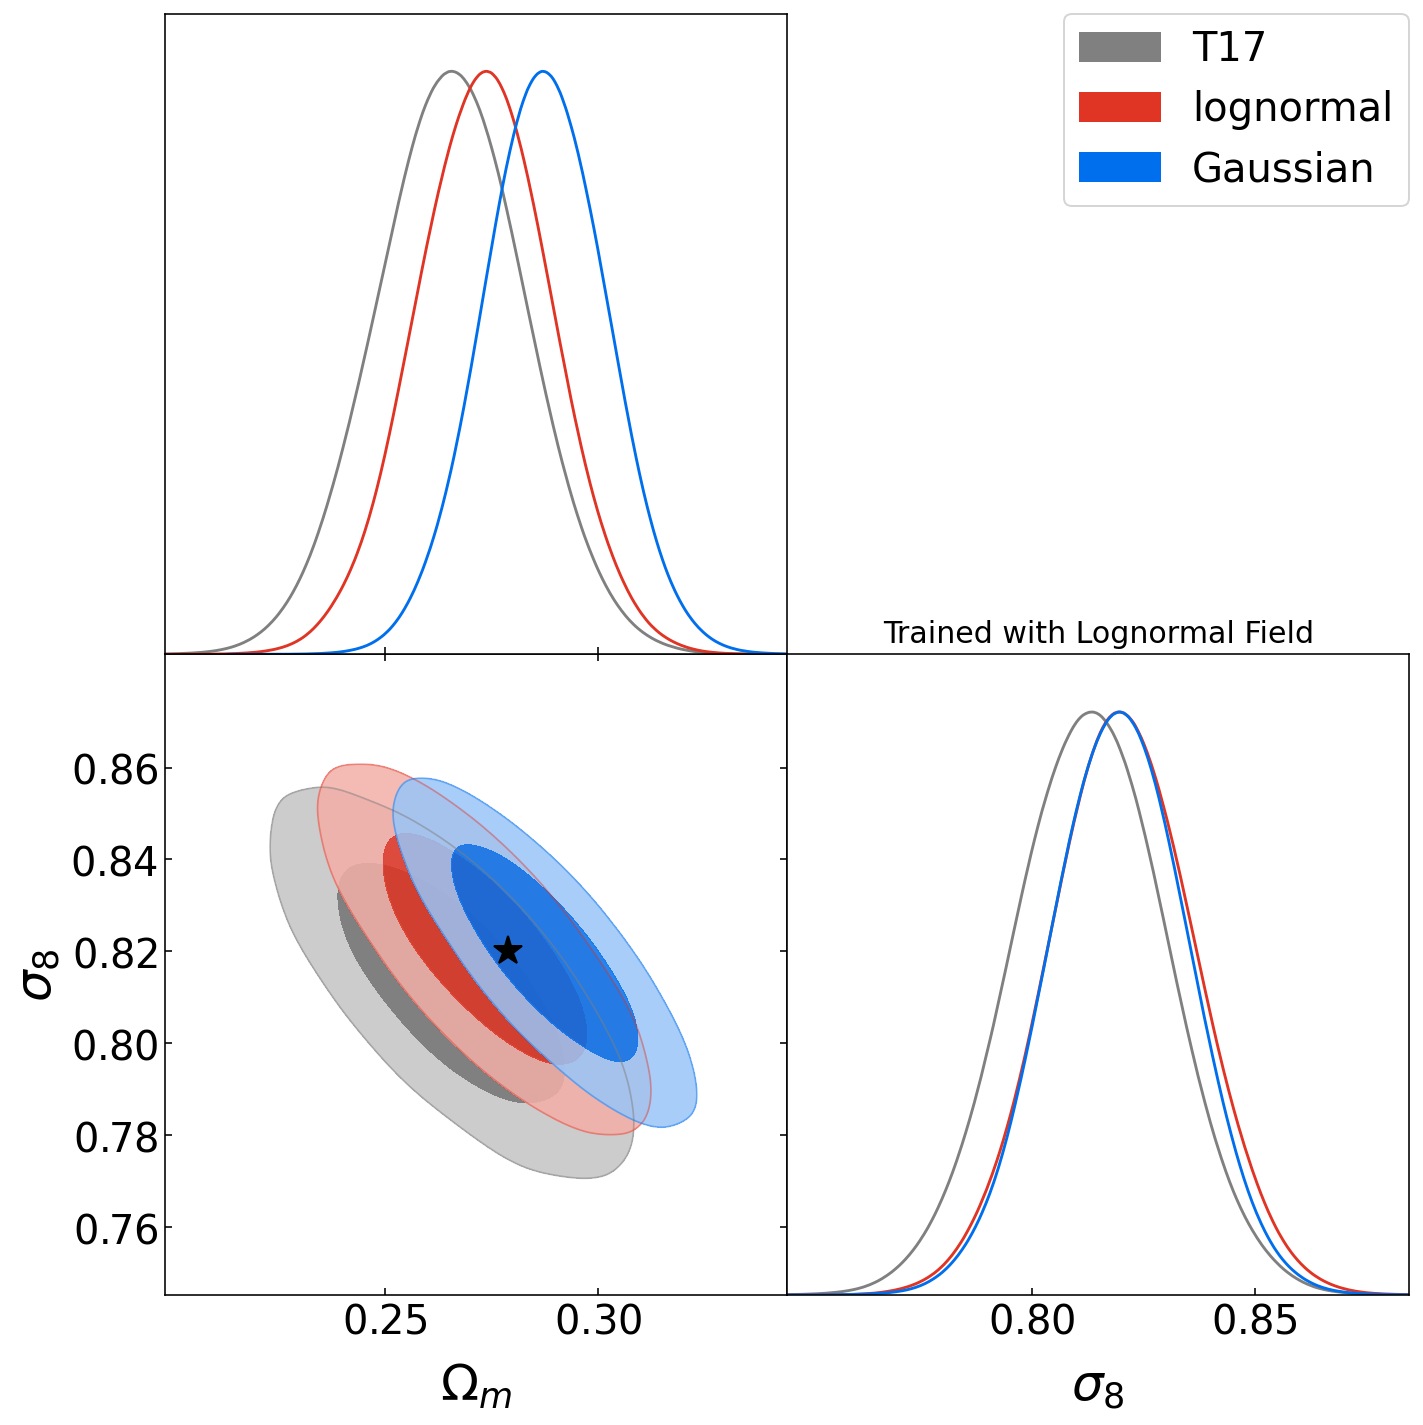

In [47]:
g = plots.get_subplot_plotter(width_inch=10)
g.settings.axes_fontsize = 20
g.settings.lab_fontsize = 25
g.settings.legend_fontsize = 20
g.triangle_plot(all_samples_lognormal_11, filled=True, legend_labels=labels, legend_loc='upper right')
g.subplots[1, 0].plot([fiducial_Omega_M], [fiducial_sigma_8], marker='*', label='Fiducial Cosmology', markersize=15, color="black")
plt.title('Trained with Lognormal Field',fontsize=15)
#plt.savefig('/home/r/R.Kanaki/Master_Arbeit_Final//Plot/Posterior_v6/Posterior_Train_lognormal_11.jpg', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

#### Was Gaussian ein bisschen kleiner,,, scheiße

In [48]:
nsamp = 100000
samples_T17_0 = np.random.multivariate_normal(parameter_est_T17_lognormal_1[0], cov_para_T17_lognormal_1[:,:,0], size=nsamp)
samples_T17_1 = np.random.multivariate_normal(parameter_est_T17_lognormal_1[1], cov_para_T17_lognormal_1[:,:,1], size=nsamp)
samples_T17_2 = np.random.multivariate_normal(parameter_est_T17_lognormal_1[2], cov_para_T17_lognormal_1[:,:,2], size=nsamp)
samples_T17_3 = np.random.multivariate_normal(parameter_est_T17_lognormal_1[3], cov_para_T17_lognormal_1[:,:,3], size=nsamp)
samples_T17_4 = np.random.multivariate_normal(parameter_est_T17_lognormal_1[4], cov_para_T17_lognormal_1[:,:,4], size=nsamp)
samples_T17_5 = np.random.multivariate_normal(parameter_est_T17_lognormal_1[5], cov_para_T17_lognormal_1[:,:,5], size=nsamp)
samples_T17_0_mcsamples = MCSamples(samples=samples_T17_0, names=param_names, labels=param_names, label='Realization 0', ranges=prior_ranges)
samples_T17_1_mcsamples = MCSamples(samples=samples_T17_1, names=param_names, labels=param_names, label='Realization 1', ranges=prior_ranges)
samples_T17_2_mcsamples = MCSamples(samples=samples_T17_2, names=param_names, labels=param_names, label='Realization 2', ranges=prior_ranges)
samples_T17_3_mcsamples = MCSamples(samples=samples_T17_3, names=param_names, labels=param_names, label='Realization 3', ranges=prior_ranges)
samples_T17_4_mcsamples = MCSamples(samples=samples_T17_4, names=param_names, labels=param_names, label='Realization 4', ranges=prior_ranges)
samples_T17_5_mcsamples = MCSamples(samples=samples_T17_5, names=param_names, labels=param_names, label='Realization 5', ranges=prior_ranges)

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


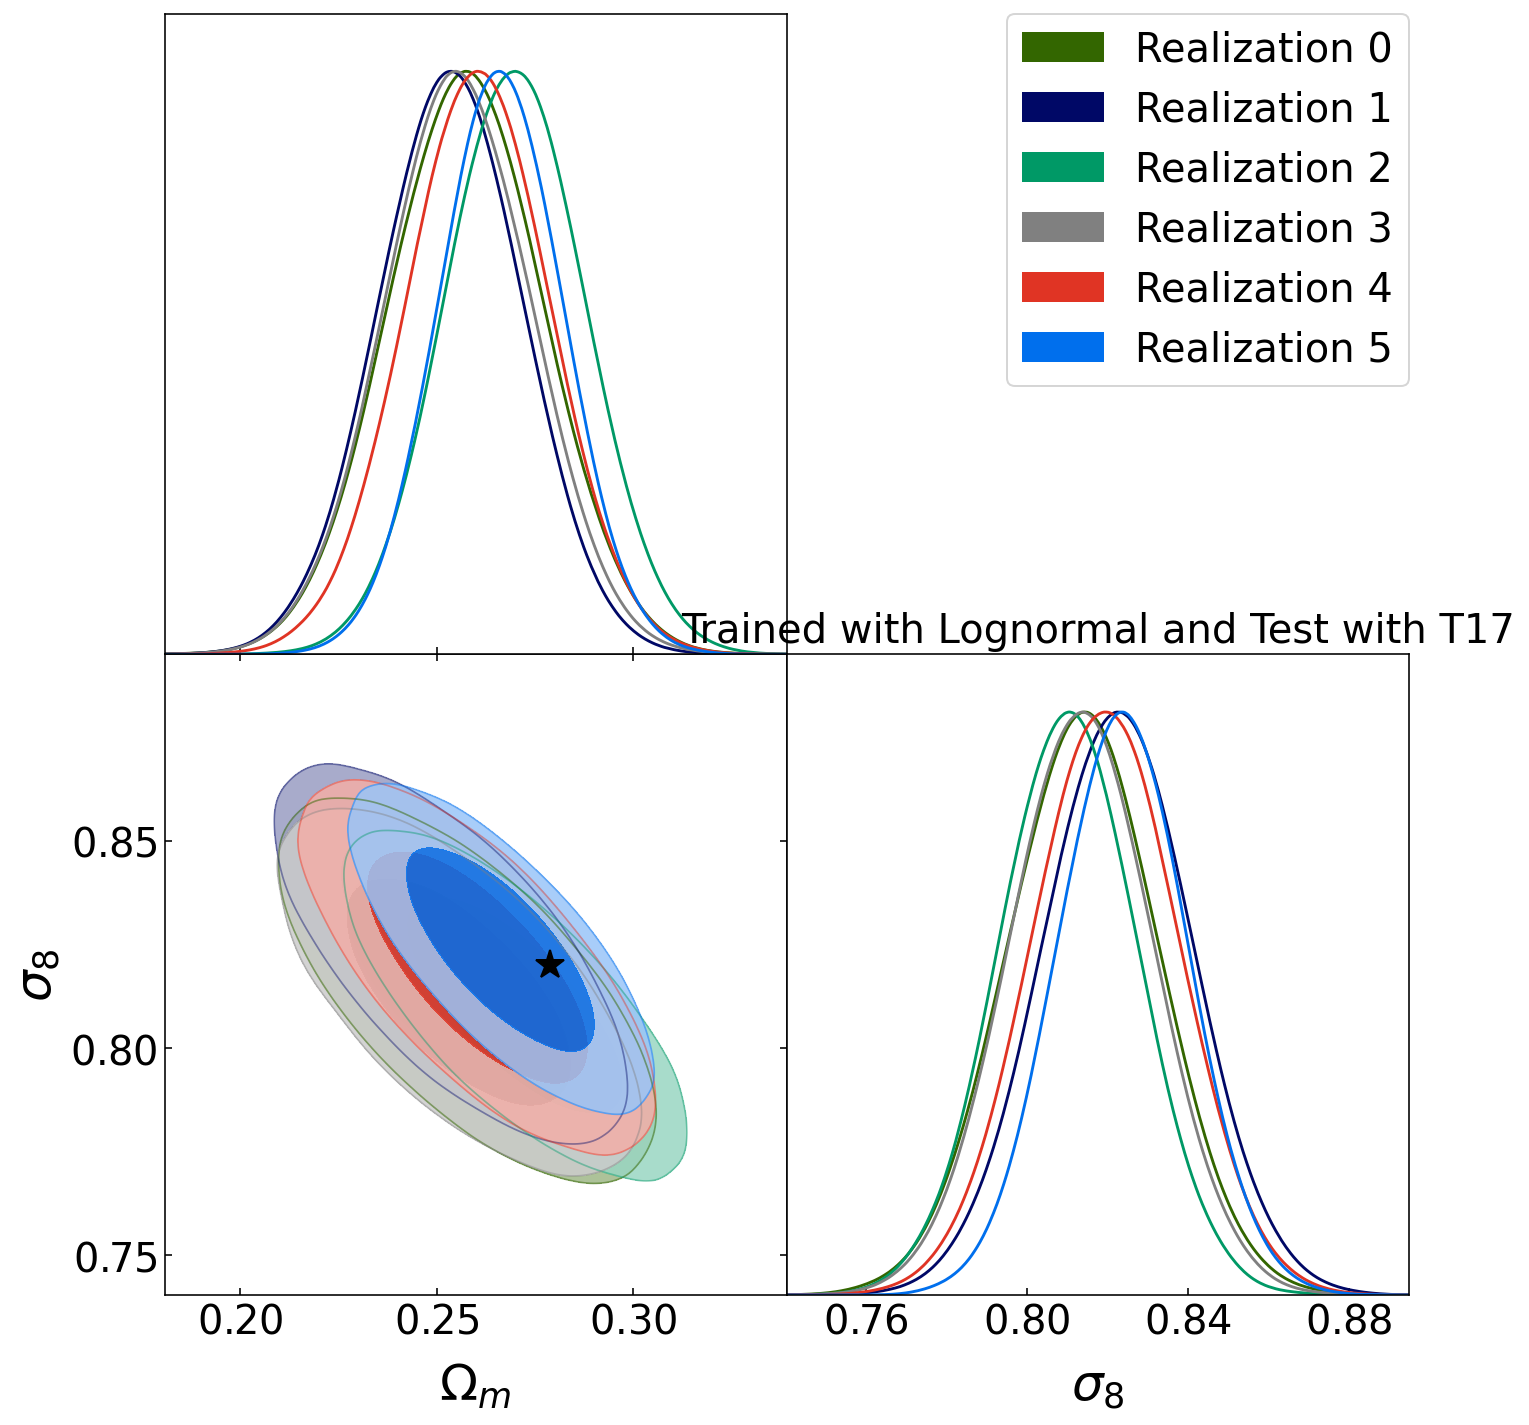

In [50]:
all_samples_various_universe = [samples_T17_0_mcsamples, samples_T17_1_mcsamples, samples_T17_2_mcsamples,samples_T17_3_mcsamples,samples_T17_4_mcsamples,samples_T17_5_mcsamples]
labels_various_universe = ['Realization 0', 'Realization 1','Realization 2','Realization 3','Realization 4','Realization 5']
# Create a getdist Plotter
g = plots.get_subplot_plotter(width_inch=10)
g.settings.axes_fontsize = 20
g.settings.lab_fontsize = 25
g.settings.legend_fontsize = 20
# Plot the triangle plot with all posterior distributions and priors
g.triangle_plot(all_samples_various_universe, filled=True, legend_labels=labels_various_universe, legend_loc='upper right')
g.subplots[1, 0].plot([fiducial_Omega_M], [fiducial_sigma_8], marker='*', label='Fiducial Cosmology', markersize=15, color="black")
plt.scatter(fiducial_Omega_M, fiducial_sigma_8, marker='*', s=300, label="fiducial cosmology")
# Save the plot to a file (optional)
plt.title('Trained with Lognormal and Test with T17',fontsize=20)
#plt.savefig('/home/r/R.Kanaki/Master_Arbeit_Final//Plot/Posterior_v6/Posterior_various_universe.jpg', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

#### Es ist nicht so stabil, nicht geil

# Part 4. Figure of Merit

#### It is attack point of your yugioh card, correlation coeficient is defence point.
#### CMB PLANCK is ultra rare, DES is gold rare.
#### You can calculate like this:
$$
FOM=\frac{1}{\sqrt{\mathrm{det}(\boldsymbol{\Sigma})}}=\frac{1}{\sqrt{\Pi^N_i\lambda_i}}
$$

In [51]:
def figure_of_merit(posterior_samples):
    cov_matrix = np.cov(posterior_samples.T)
    eigvals, _ = np.linalg.eig(cov_matrix)
    return 1.0 / np.sqrt(np.prod(eigvals))

In [55]:
all_samples_cov_mean_11 = [samples_T17_Gauss_1_mcsamples, samples_T17_lognormal_1_mcsamples, samples_lognormal_1_Gauss_1_mcsamples, samples_lognormal_1_lognormal_1_mcsamples, samples_Gauss_1_Gauss_1_mcsamples, samples_Gauss_1_lognormal_1_mcsamples]
labels = ['Trained with Gauss, Test with T17', 'Trained with Lognormal, Test with T17','Trained with Gauss, Test with lognormal', 'Trained with lognormal, Test with lognormal', 'Trained with Gauss, Test with Gauss', 'Trained with lognormal, Test with Gauss']
foms_mean_11= []
for sample in all_samples_cov_mean_11:
    fom = figure_of_merit(sample.samples)
    foms_mean_11.append(fom)
all_samples_cov_KDE_11 = [samples_T17_Gauss_1_mcsamples_KDE, samples_T17_lognormal_1_mcsamples_KDE, samples_lognormal_1_Gauss_1_mcsamples_KDE, samples_lognormal_1_lognormal_1_mcsamples_KDE, samples_Gauss_1_Gauss_1_mcsamples_KDE, samples_Gauss_1_lognormal_1_mcsamples_KDE]
foms_KDE_11= []
for sample in all_samples_cov_KDE_11:
    fom = figure_of_merit(sample.samples)
    foms_KDE_11.append(fom)

<Figure size 864x576 with 0 Axes>

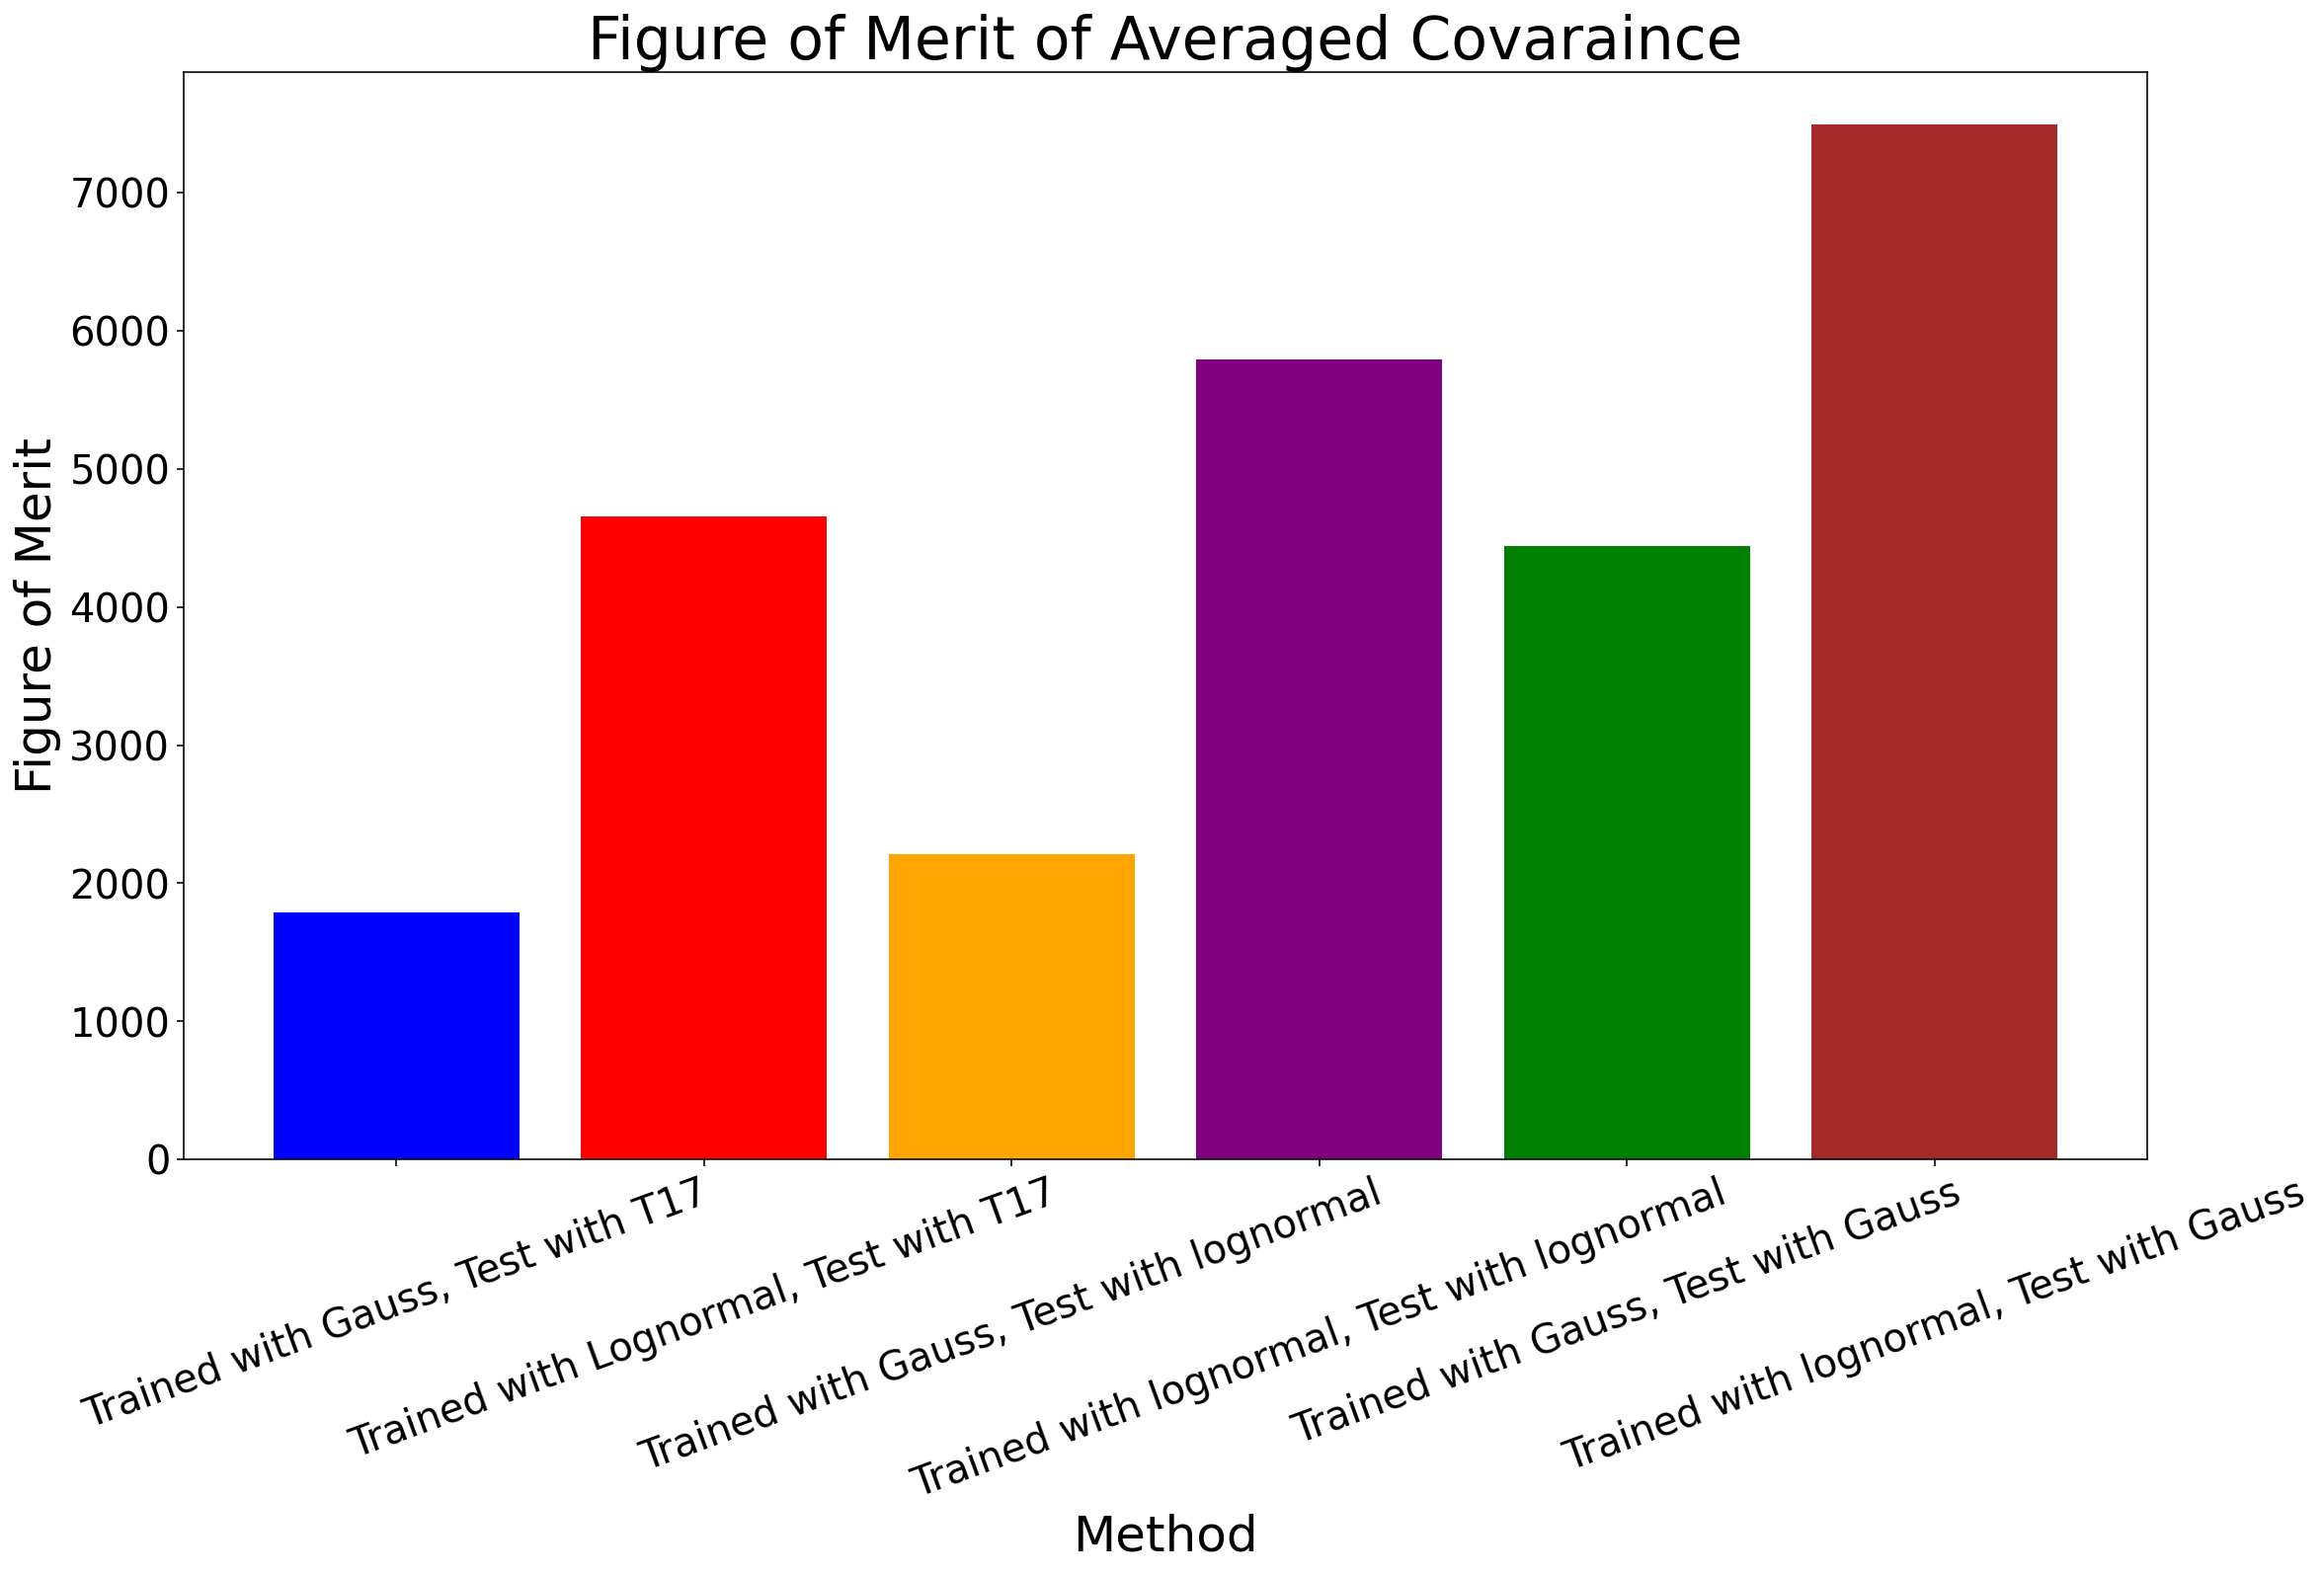

In [57]:
# Create a bar plot
plt.figure(figsize=(12, 8))
# Define custom colors for each bar
colors = ['blue', 'red', 'orange', 'purple', 'green', 'brown']

# Create a bar plot
plt.figure(figsize=(15, 10))
bars = plt.bar(labels, foms_mean_11, color=colors)

# Add legend with the corresponding labels
#plt.legend(bars, labels, loc='upper right', bbox_to_anchor=(1.20, 1.20))

plt.xlabel('Method', fontsize=25)
plt.ylabel('Figure of Merit', fontsize=25)
plt.title('Figure of Merit of Averaged Covaraince',fontsize=30)
plt.xticks(rotation=20)
plt.tight_layout()
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
#plt.savefig('/home/r/R.Kanaki/Master_Arbeit_Final/Plot/Posterior_v6/FOM_11.jpg',bbox_inches='tight')
# Display the plot
plt.show();

#### Too bad, no comment... I just consider...

<Figure size 864x576 with 0 Axes>

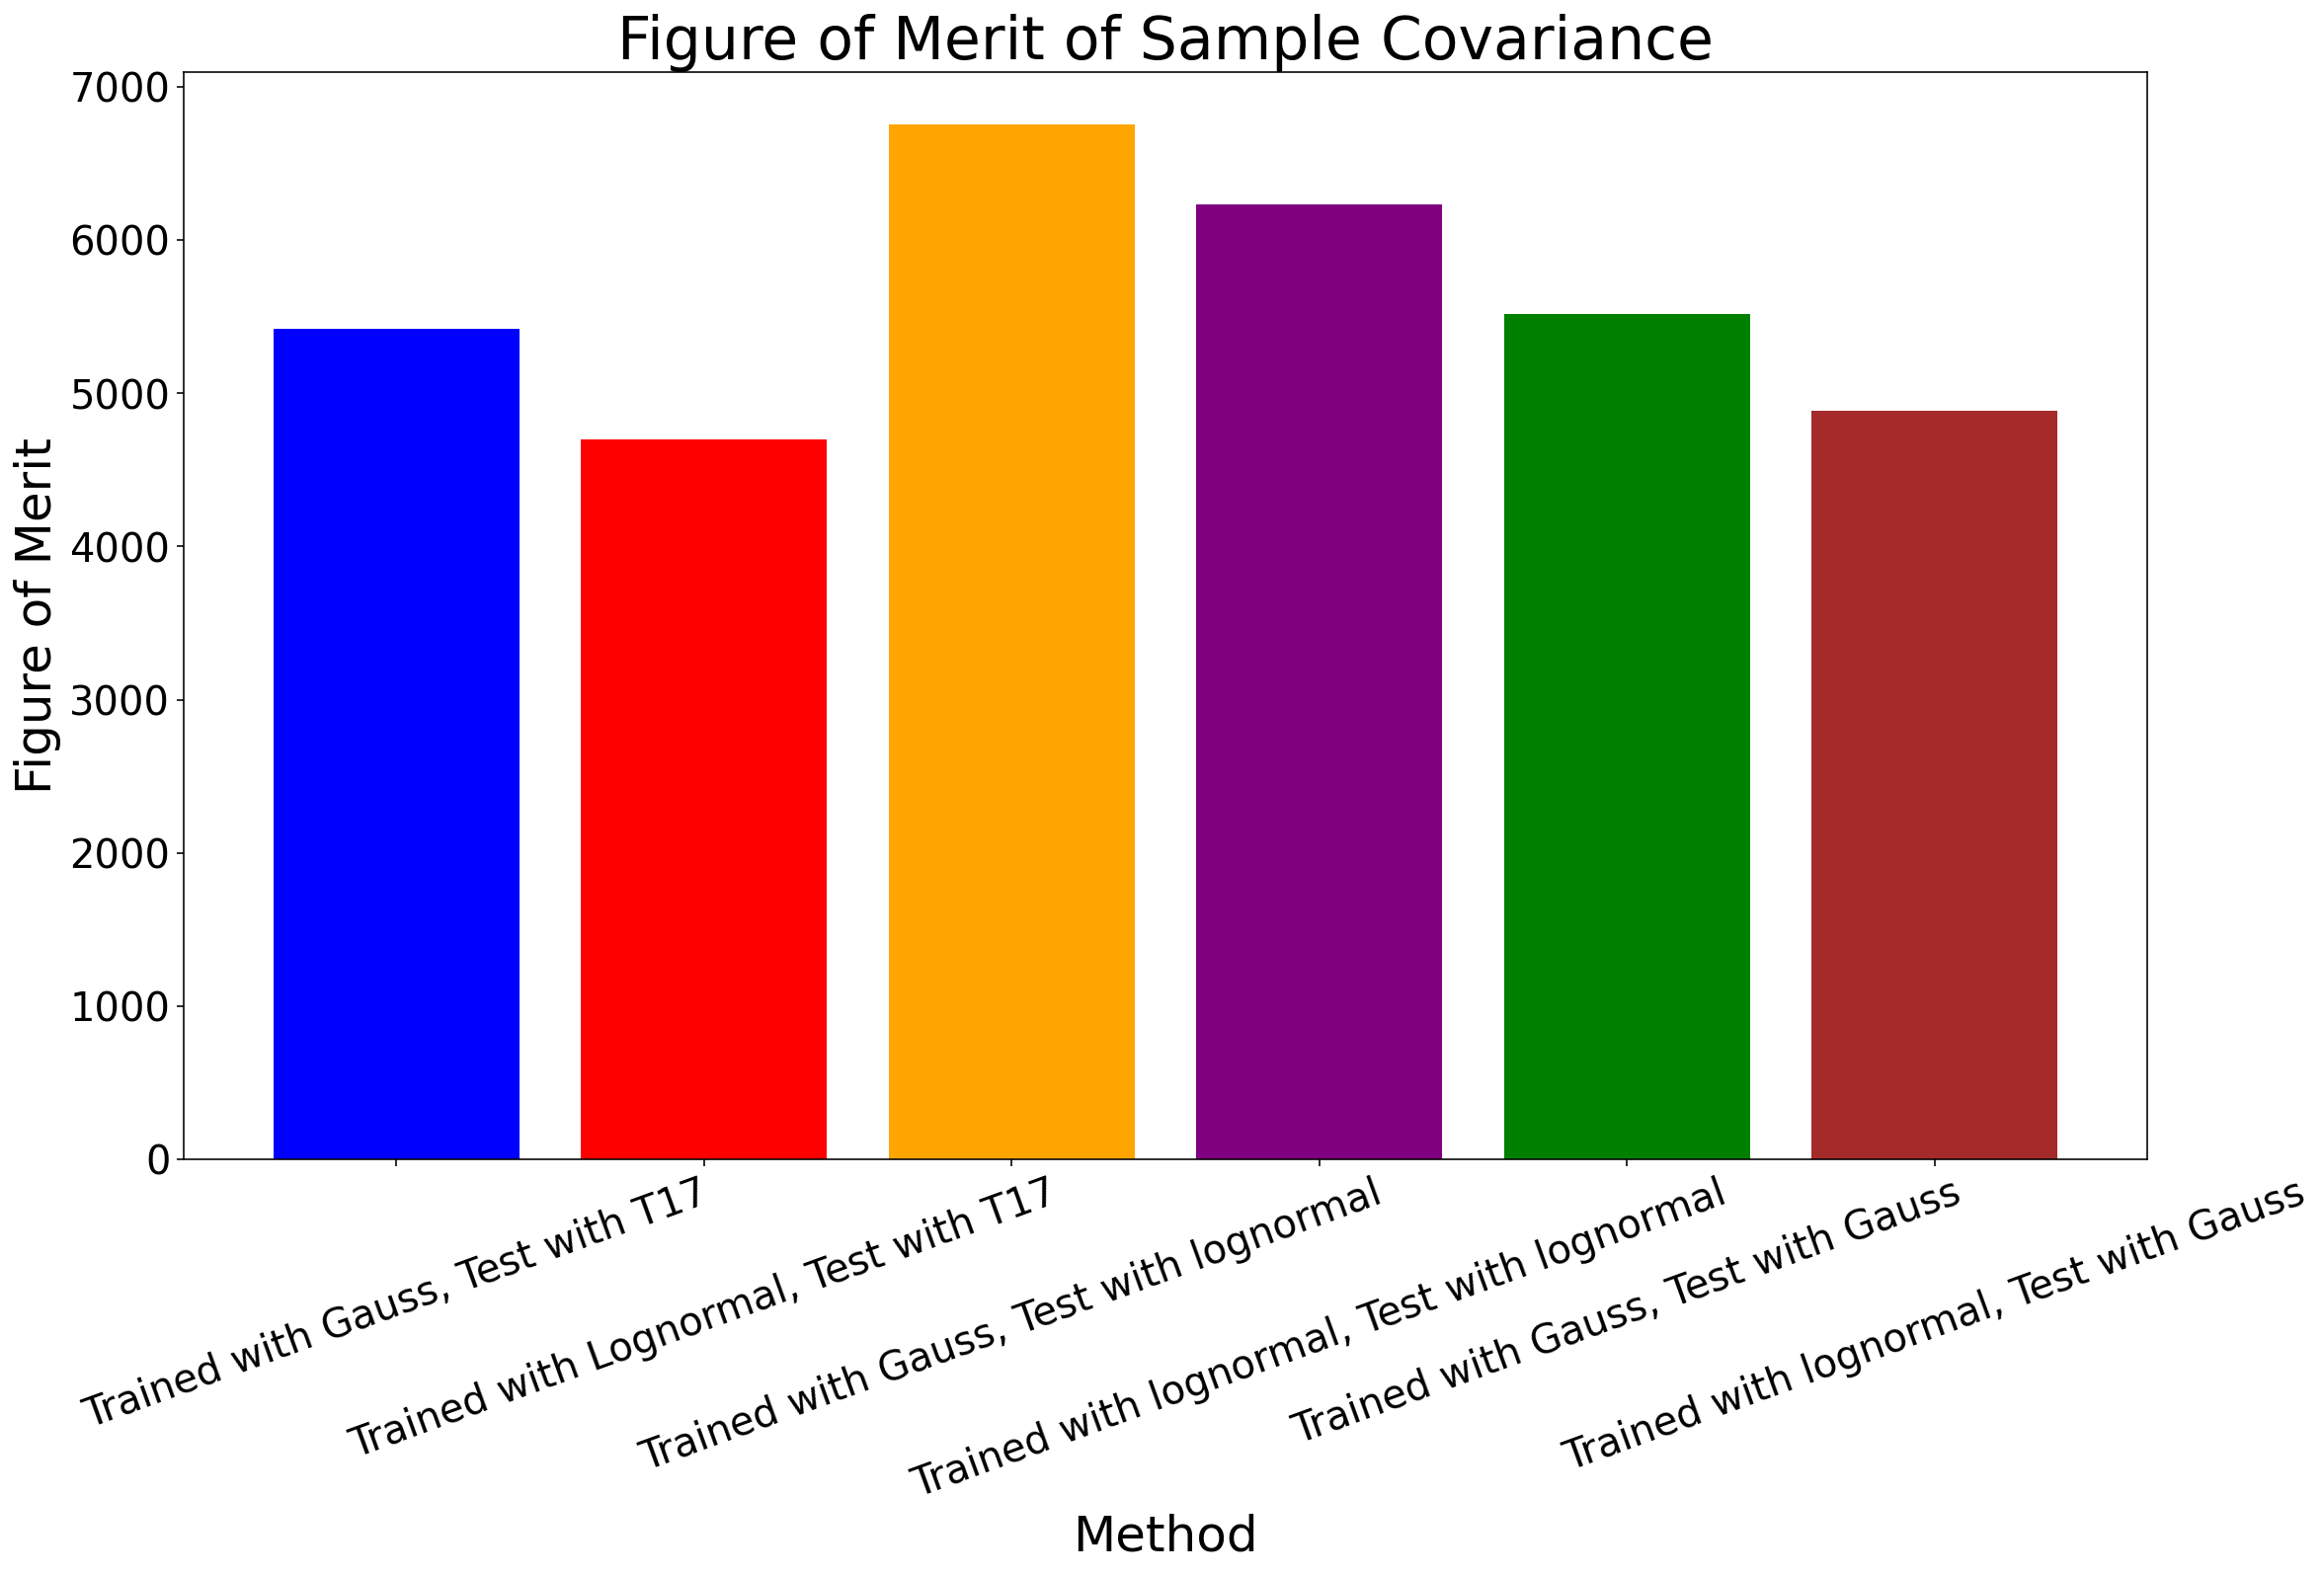

In [58]:
# Create a bar plot
plt.figure(figsize=(12, 8))
# Define custom colors for each bar
colors = ['blue', 'red', 'orange', 'purple', 'green', 'brown']

# Create a bar plot
plt.figure(figsize=(15, 10))
bars = plt.bar(labels, foms_KDE_11, color=colors)

# Add legend with the corresponding labels
#plt.legend(bars, labels, loc='upper right', bbox_to_anchor=(1.20, 1.20))

plt.xlabel('Method', fontsize=25)
plt.ylabel('Figure of Merit', fontsize=25)
plt.title('Figure of Merit of Sample Covariance',fontsize=30)
plt.xticks(rotation=20)
plt.tight_layout()
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.savefig('/home/r/R.Kanaki/Master_Arbeit_Final/Plot/Posterior_v6/FOM_KDE_11.jpg',bbox_inches='tight')
# Display the plot
plt.show();

#### Ok, non capisco un cazzo